# Exploring noise amplification on basis gates

Understanding the behavior of a noise amplification technique and how it interacts with different circuits can be very helpful when choosing a strategy for your ZNE experiment. Ultimately, any circuit you execute on quantum hardware gets transpiled down to an equivalent circuit using only the basis gates of the device. Let's explore how amplifying the noise of the basis gates of a device using gate folding affects estimation of expectation values on real quantum hardware.

## Dependencies

We'll start by importing a few dependencies.

In [ ]:
# for loading execution context parameters from the environment
import os
from dotenv import load_dotenv

# for (de)serializing results
import json

# for processing data
import numpy as np

# for plotting results
import matplotlib as mpl
import matplotlib.pyplot as plt

# for defining the circuits and observables constituting our expectation value problems
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# for using real quantum hardware
from qiskit import IBMQ, transpile
from qiskit_ibm_runtime import QiskitRuntimeService

Next, we'll import from the `zne` package
1. `ZNEStrategy`, which allows us to specify which noise amplifier, extrapolator, and noise factors to use for our experiment;
2. `Estimator`, which estimates our expectation value using ZNE on real hardware (we import it as `ZneEstimator` for clarity); and
3. `NoiseAmplifier`, which is the interface that allows us to define a custom noise amplifier. 

In [1]:
from zne import ZNEStrategy
from zne import Estimator as ZneEstimator
from zne.noise_amplification import NoiseAmplifier

## Execution Context

Let's set our execution context. We start by fetching the configuration from environment variables. Make sure to add a `.env` file in the same directory as this notebook with values for these environment variables before running the following cells.

Here's an example of what your `.env` file might look like:

```bash
TOKEN=6dc252b6700cd1297aa9936ca70f16c52326b6247fb6006dd2171d5845abeac86f7f265b20fd49e2098f4bec5b33d3805204f35c5463d4adf1994d41135bd80c
HUB=ibm-q
GROUP=open
PROJECT=main
BACKEND=ibmq_lima
```

In [2]:
load_dotenv()

TOKEN = os.environ["TOKEN"]

HUB = os.environ["HUB"]
GROUP = os.environ["GROUP"]
PROJECT = os.environ["PROJECT"]

BACKEND = os.environ["BACKEND"]

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", instance=f"{HUB}/{GROUP}/{PROJECT}", token=TOKEN)

In [43]:
IBMQ.enable_account(TOKEN)
provider = IBMQ.get_provider(hub=HUB, group=GROUP, project=PROJECT)
backend = provider.get_backend(BACKEND)

## Presentation Utilities

Next, let's configure how we want our plots to be drawn and define a few utility functions to help make plotting our results simpler.

In [66]:
mpl.rcParams['figure.dpi'] = 500
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman"
})

In [6]:
def plot_trial(
    noise_factors,
    measured_evs,
    measured_errors,
    trial_id="A",
    alpha=0.5,
    color="#dc267f",
):
    plt.plot(noise_factors, measured_evs, label=f"Measured (Trial {trial_id})", color=color)
    plt.fill_between(
        noise_factors,
        measured_evs - measured_errors,
        measured_evs + measured_errors,
        alpha=alpha,
        color=color,
        linewidth=0
    )

In [7]:
def show_experiment(
    trials,
    exact_ev,
    experiment_repr,
    observable_repr,
    num_shots=4000,
    ev_range=None
):
    noise_factors = np.array(trials[0]["noise_factors"])
    plt.plot([0, noise_factors[-1]], [exact_ev, exact_ev], "--", label=f"Exact", color="#000000")
    for trial_id, color, measured_data in zip(('A', 'B'), ("#dc267f", "#785ef0"), trials):
        measured_evs = np.array(measured_data["values"])
        measured_errors = np.sqrt(np.array(measured_data["variances"]) / num_shots)
        plot_trial(
            noise_factors,
            measured_evs,
            measured_errors,
            trial_id=trial_id,
            color=color
        )
    plt.title(experiment_repr)
    plt.xlabel("Noise Factor ($n$)")
    plt.ylabel(f"Expectation Value ($\langle {observable_repr} \\rangle$)")
    if ev_range: 
        plt.ylim(ev_range)
    plt.legend()
    plt.show()

## Noise Amplifier

Now we're ready to define our noise amplifier. Folding a common noise amplification technique; when you fold a circuit, each gate expands to include repeats of itself and its inverse (which leaves the circuit logically unchanged but accumulates the noise associated with applying the gate). The number of gates each gate expands into is referred to as the **noise factor**. ZNE's `LocalFoldingAmplifier` and `GlobalFoldingAmplifier` currently fold *all gates*. We want to fold only *the basis gate of interest* in our experiments. To use a custom noise amplifier with ZNE, all we have to do is implement the `NoiseAmplifier` interface.

Let's define a `SingleGateFoldingAmplifier` noise amplifier that takes the name of a gate and, when asked to amplify the noise of a circuit, replaces each instance of that gate in the circuit with a length-`noise_factor` alternating sequence of itself and its inverse.

In [8]:
class SingleGateFoldingAmplifier(NoiseAmplifier):
    def __init__(self, gate_name: str):
        self.gate_name = gate_name

    def amplify_circuit_noise(self, circuit: QuantumCircuit, noise_factor: float) -> QuantumCircuit:
        noisy_circuit = circuit.copy_empty_like()
        for instruction, qargs, cargs in circuit:
            if instruction.name == self.gate_name:
                for i in range(noise_factor):
                    if i % 2 == 0:
                        noisy_circuit.append(instruction, qargs, cargs)
                    else:
                        noisy_circuit.append(instruction.inverse(), qargs, cargs)
                    noisy_circuit.barrier(qargs)
            else:
                noisy_circuit.append(instruction, qargs, cargs)
        return noisy_circuit

Finally, we're ready to write some experiments! The backend we're using (`ibmq_kolkata`) has 4 basis gates: $X$, $\sqrt X$, $R_z(\theta)$, and $CX$. For each basis gate, we'll have a circuit with the basis gate and an observable (with a non-zero expectation value for the circuit) and ask the quantum hardware to give us the expectation value of the observable for the circuit. 

We want to capture both the shorter-term granularity of basis gate folding as well as its longer-term behavior. We'll break our experiment into two regimes— **granular** and **behavioral**. The **granular** experiment will jump by the smallest $\Delta n$ possible and explore as far as keeps the number of circuits reasonable. The **behavioral** experiment will explore (roughly) the largest noise factor possible and jump by a $\Delta n$ that keeps the number of circuits reasonable.

Alright, let's code up these experiments!

## $X$ Experiment — $\langle 0|X^nZX^n|0\rangle(n)$

### Generate Experiment

For our $X$ experiment, we'll choose our circuit to be a single $X$ and our observable to be $Z$. The $X$ will put our circuit in the state $X|0\rangle=|1\rangle$, and the expectation value of $Z$ in $|1\rangle$ is $\langle 1 | Z | 1 \rangle=\langle 1 | (-| 1 \rangle)=-\langle 1 | 1 \rangle=-1$

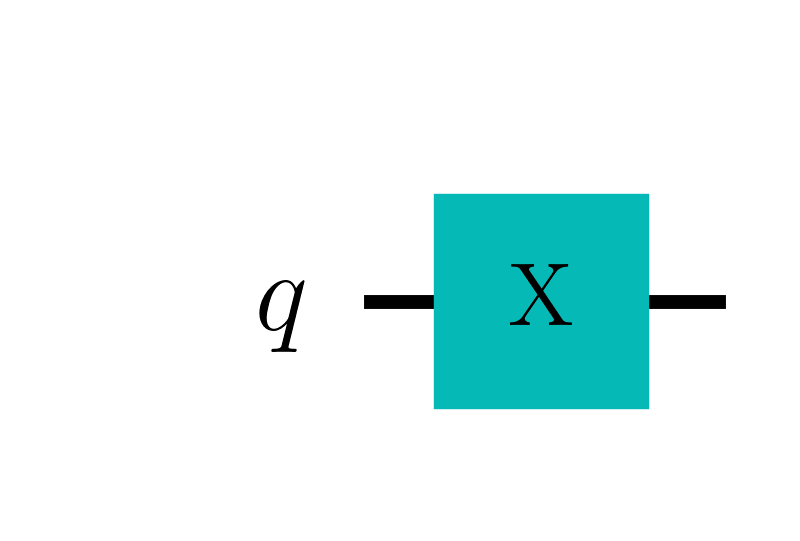

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])
-1.0


In [67]:
x_circuit = QuantumCircuit(1)
x_circuit.x(0)

x_observable = SparsePauliOp.from_list([('Z', 1)])

x_exact_ev = -1.0

display(x_circuit.draw("mpl"))
print(x_observable)
print(x_exact_ev)

Next we'll define our granular and behavioral noise factors with our limit of $300$ circuits/job in mind. For the granular noise factor range, we'll jump from by $\Delta n=2$ from $n_0=1$ fixing our final noise factor to $599$. For the behavioral noise factor range, we'll jump to $5999$ from $n_0=1$ fixing our jump size to $\Delta n=20$.

In [12]:
x_granular_noise_factors = tuple(range(1, 599 + 2, 2))
x_behavioral_noise_factors = tuple(range(1, 5999, 20))

### Run Experiment

We're ready to run our first experiment! For each regime, we'll perform two trials to see how the behavior shifts from run to run.

#### Granular

##### Trial A

We start by spinning up a `ZneEstimator` and passing in our circuit and observable. We also specify a `service` which houses our IBMQ credentials and a backend through the `options` dictionary. Finally, we pass in a `ZNEStrategy` with our sequence of noise factors for this regime and noise amplifier. 

Inside the `ZneEstimator` context, we call `estimator` with the indices of the circuit and the observable from the list we passed in at construction to compute the expectation value of our observable for our circuit.

Finally, we parse through the results and dump the data to a file. 

These lines are commented, so that you don't have to wait for the experiments to run. Instead, you can just load the experimental data from the file by running the cell as-is!

In [13]:
# with ZneEstimator(
#     circuits=[x_circuit],
#     observables=[x_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=x_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     x_granular_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# x_granular_a_data = {
#     "noise_factors": list(x_granular_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(x_granular_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(x_granular_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/x/x_granular_a.json', 'w') as f:
#     json.dump(x_granular_a_data, f)

with open('data/x/x_granular_a.json', 'r') as f:
    x_granular_a_data = json.load(f)

##### Trial B

We'll do the same deal for the second trial of the granular $X$ folding experiment.

In [14]:
# with ZneEstimator(
#     circuits=[x_circuit],
#     observables=[x_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=x_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     x_granular_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# x_granular_b_data = {
#     "noise_factors": list(x_granular_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(x_granular_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(x_granular_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/x/x_granular_b.json', 'w') as f:
#     json.dump(x_granular_b_data, f)

with open('data/x/x_granular_b.json', 'r') as f:
    x_granular_b_data = json.load(f)

#### Behaviorial

Then we'll shift to using `ZNEStrategy(noise_factors=x_behavioral_noise_factors, ...)` for the behavioral $X$ folding experiment.

##### Trial A

In [15]:
# with ZneEstimator(
#     circuits=[x_circuit],
#     observables=[x_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=x_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     x_behavioral_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# x_behavioral_a_data = {
#     "noise_factors": list(x_behavioral_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(x_behavioral_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(x_behavioral_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/x/x_behavioral_a.json', 'w') as f:
#     json.dump(x_behavioral_a_data, f)

with open('data/x/x_behavioral_a.json', 'r') as f:
    x_behavioral_a_data = json.load(f)

##### Trial B

In [16]:
# with ZneEstimator(
#     circuits=[x_circuit],
#     observables=[x_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=x_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     x_behavioral_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# x_behavioral_b_data = {
#     "noise_factors": list(x_behavioral_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(x_behavioral_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(x_behavioral_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/x/x_behavioral_b.json', 'w') as f:
#     json.dump(x_behavioral_b_data, f)

with open('data/x/x_behavioral_b.json', 'r') as f:
    x_behavioral_b_data = json.load(f)

### Plot Results

Finally, we can take a look at the results!

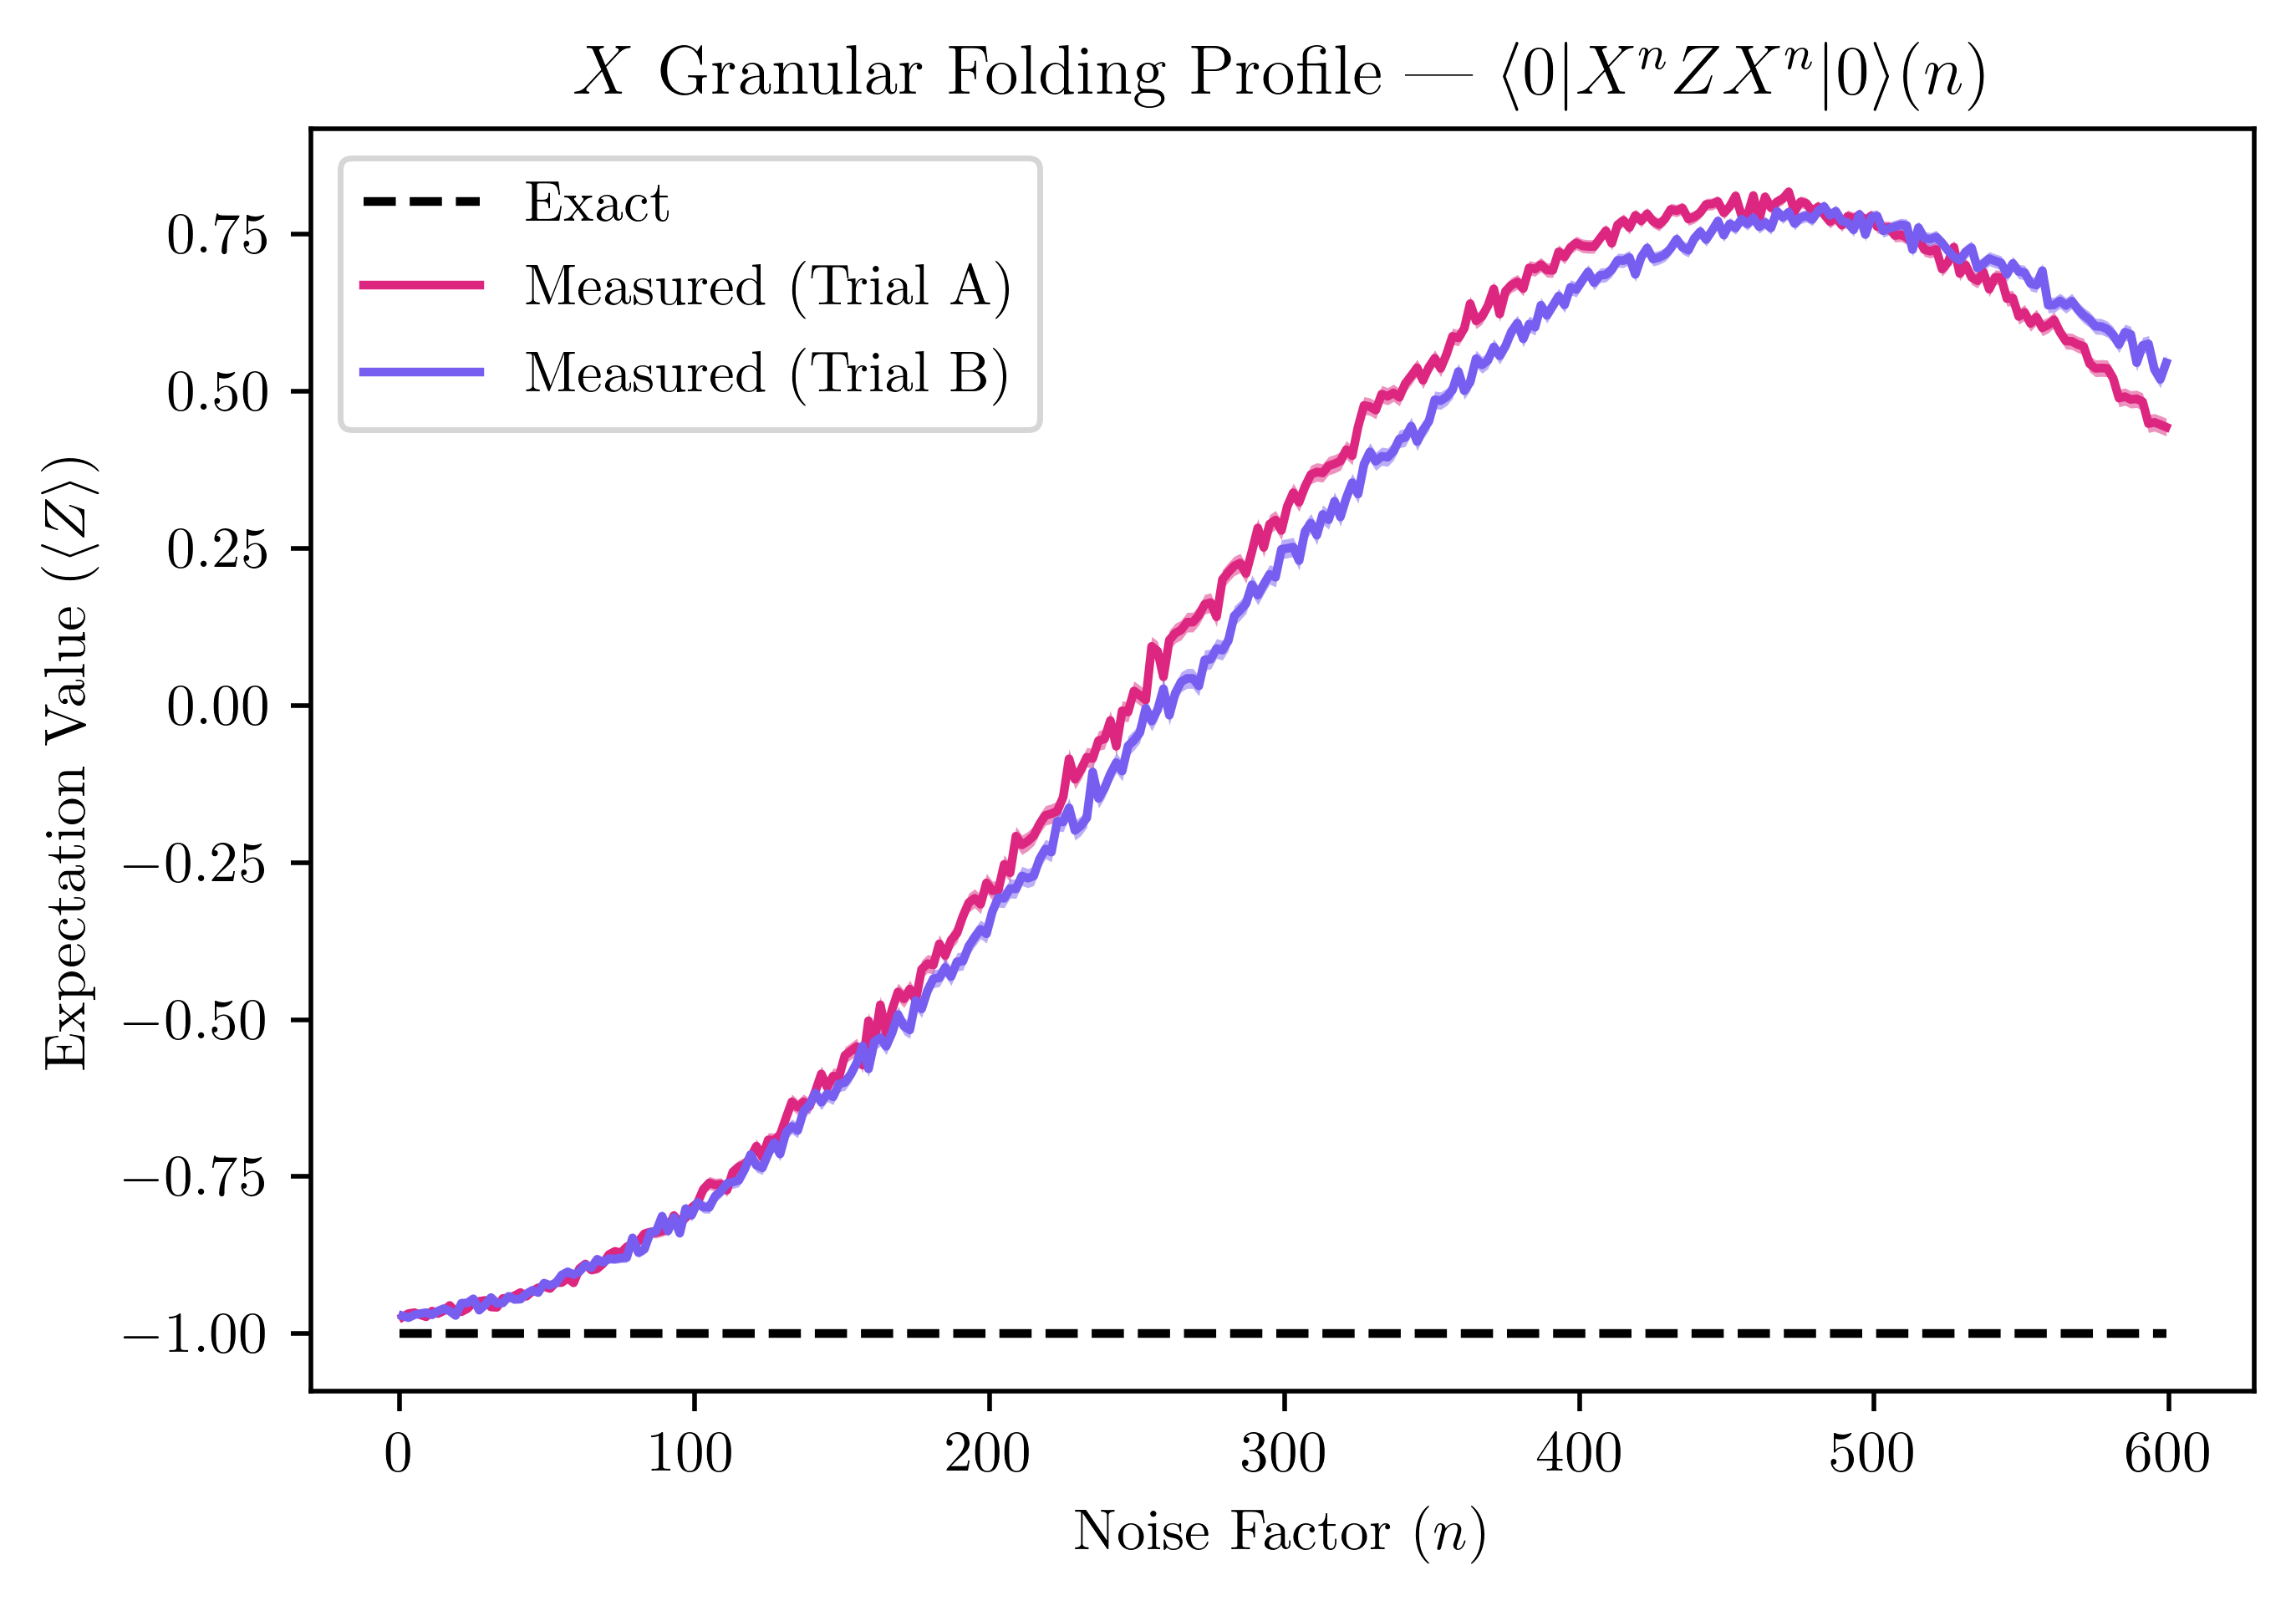

In [68]:
show_experiment([x_granular_a_data, x_granular_b_data], x_exact_ev, "$X$ Granular Folding Profile — $\langle 0 | X^n Z X^n | 0 \\rangle(n)$", 'Z')

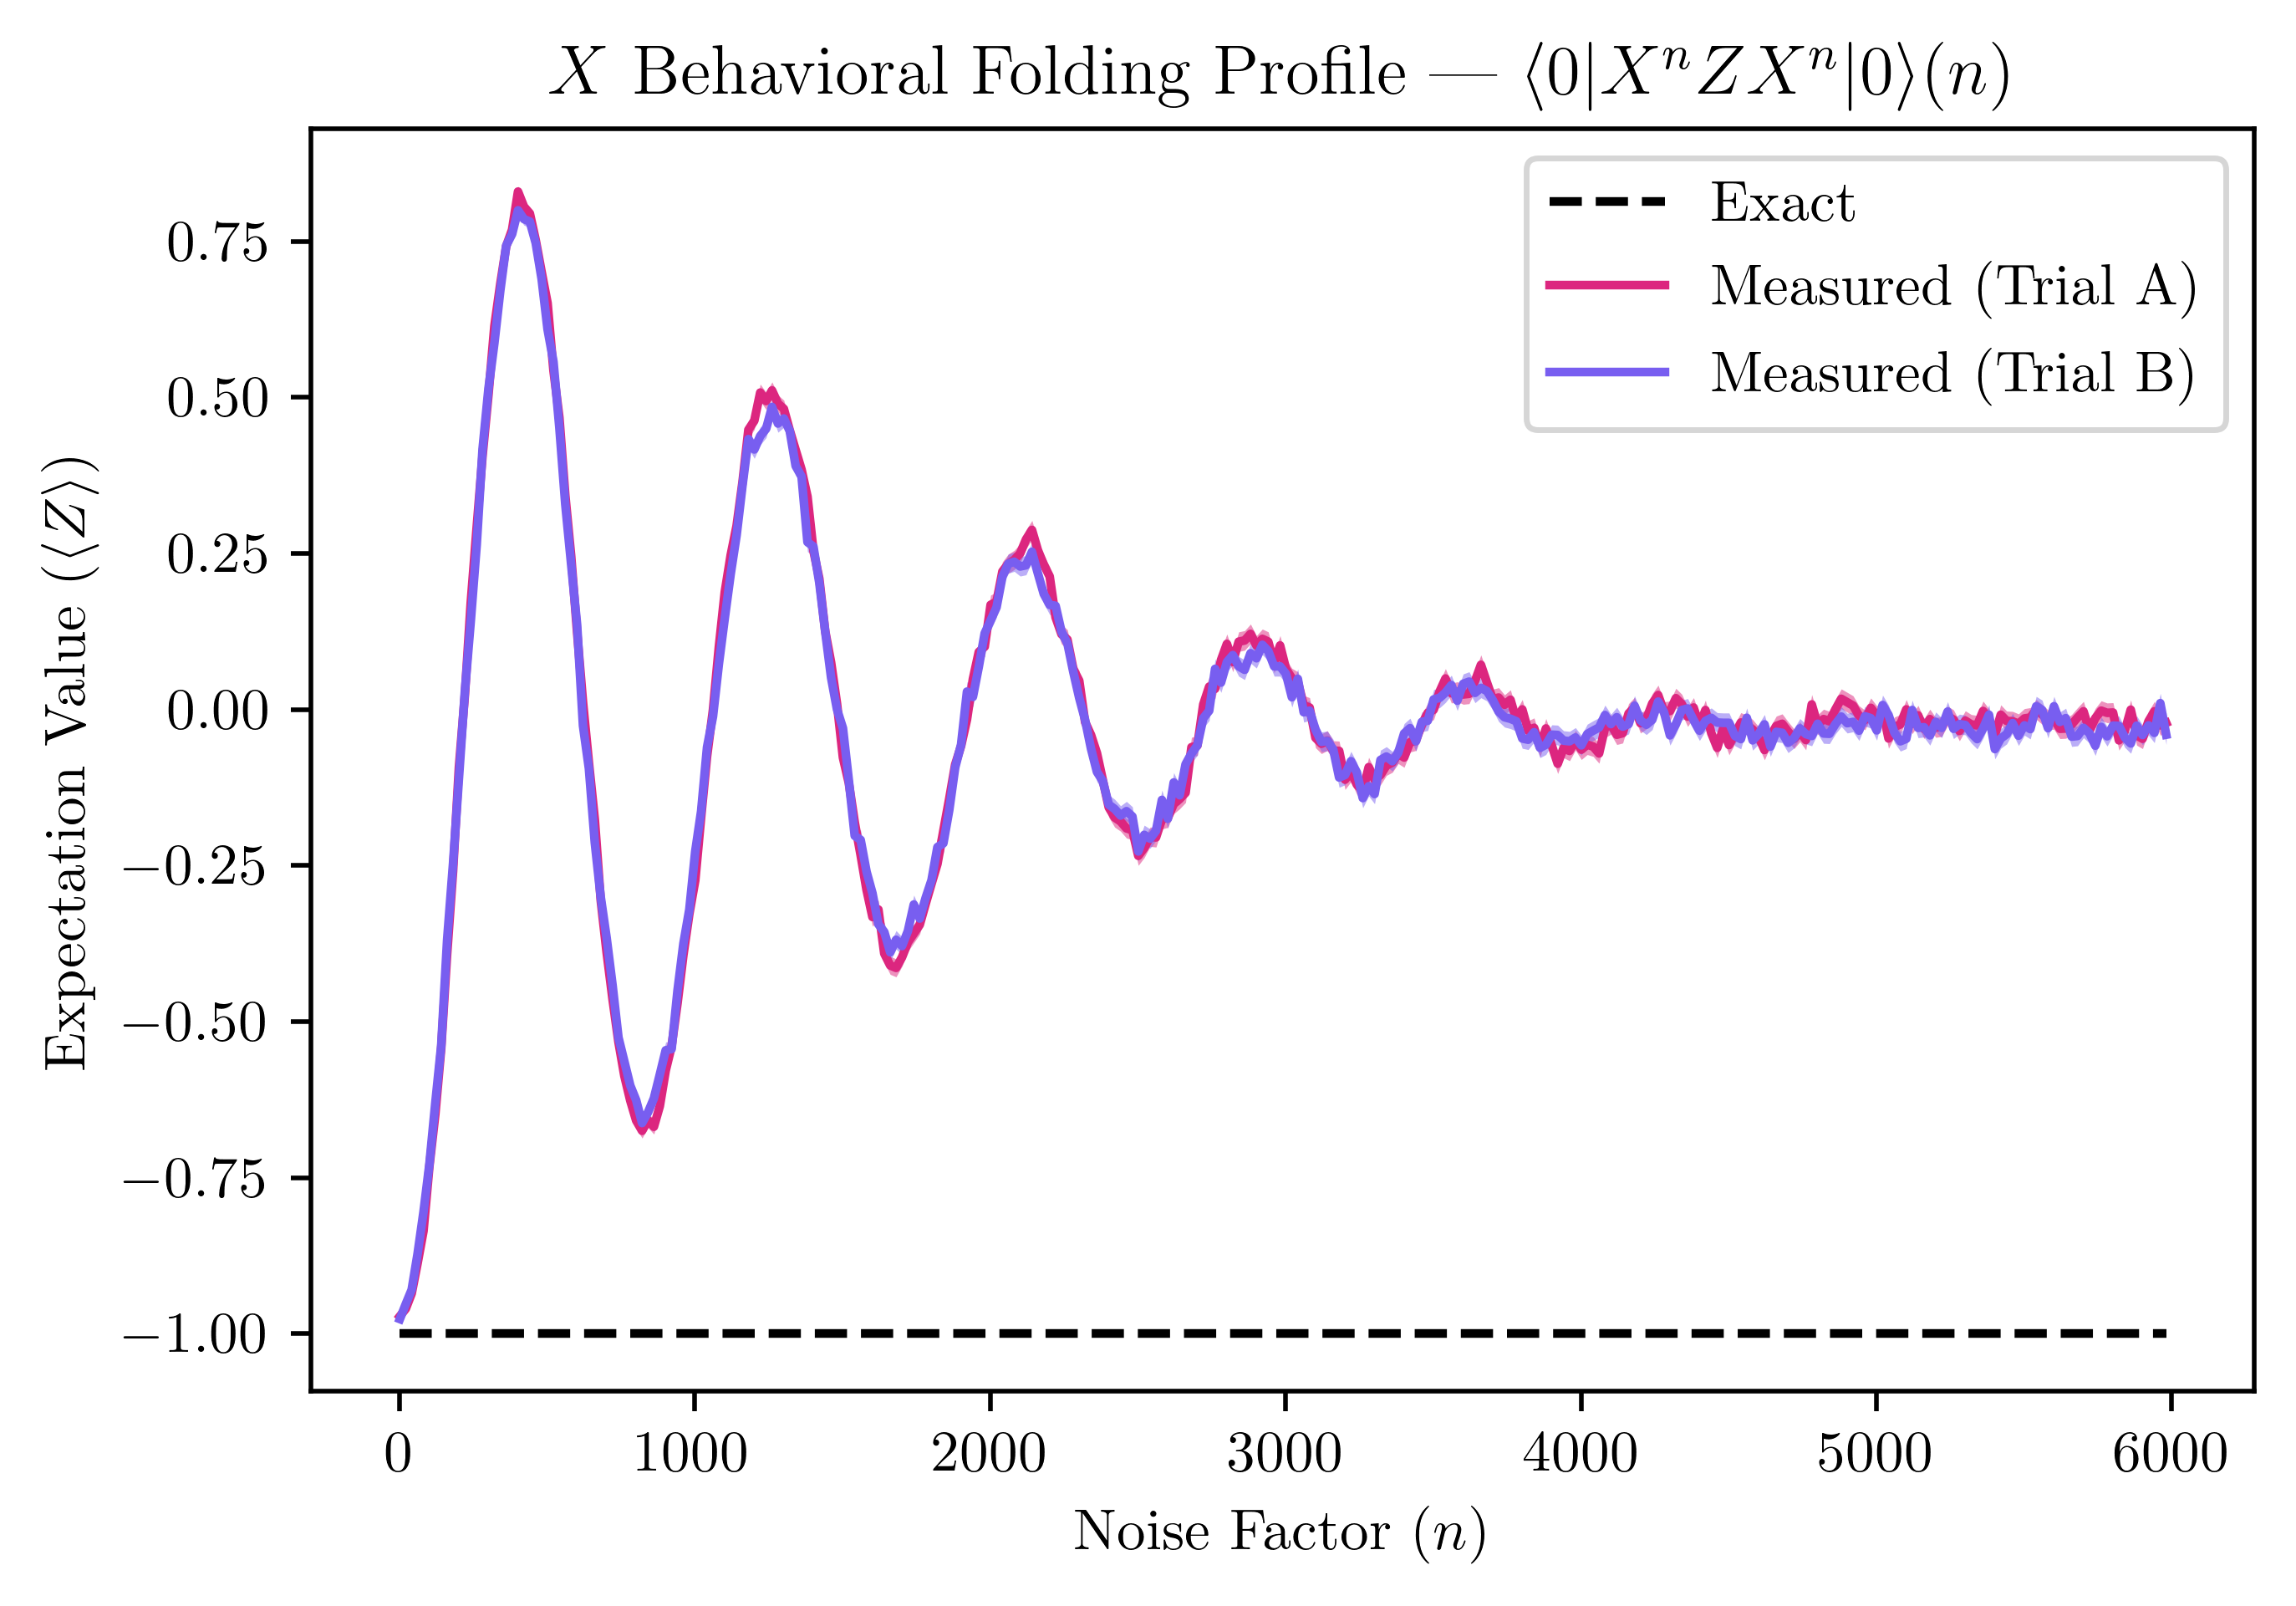

In [69]:
show_experiment([x_behavioral_a_data, x_behavioral_b_data], x_exact_ev, "$X$ Behavioral Folding Profile — $\langle 0 | X^n Z X^n | 0 \\rangle(n)$", 'Z')

The results appear to resemble a damped sinusoid in the underdamped regime.

## $\sqrt X$ Experiment — $\langle 0|{\sqrt X}^nY{\sqrt X}^n|0\rangle$

### Generate Experiment

For our $\sqrt X$ experiment, we'll choose our circuit to be a single $\sqrt X$ and our observable to be $Y$. The $\sqrt X$ will put our circuit in the state $\sqrt X|0\rangle=\frac12\left[(1+i)|0\rangle+(1-i)|1\rangle\right]$, and the expectation value of $Y$ is $\frac12\begin{pmatrix}1-i&1+i\end{pmatrix}\begin{pmatrix}0&-i\\i&0\end{pmatrix}\frac12\begin{pmatrix}1+i\\1-i\end{pmatrix}=\frac14\begin{pmatrix}1-i&1+i\end{pmatrix}\begin{pmatrix}-i-1\\i-1\end{pmatrix}=\frac14(-4)=-1$.

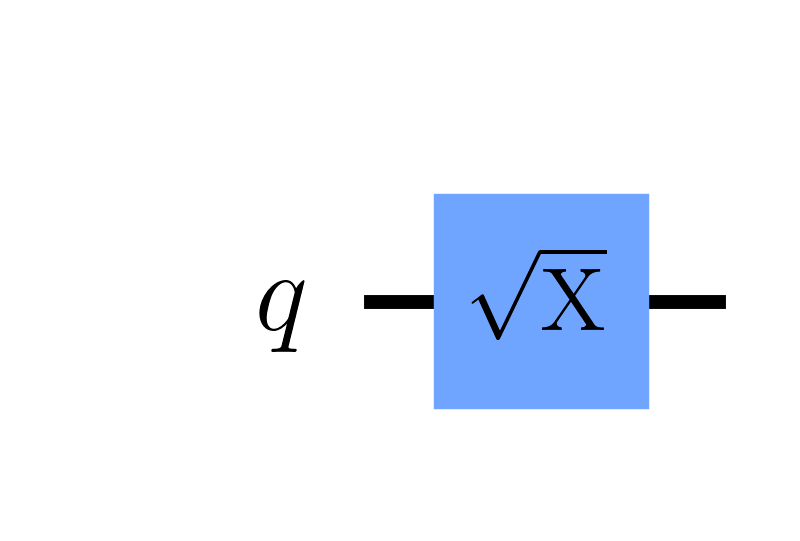

SparsePauliOp(['Y'],
              coeffs=[1.+0.j])
-1.0


In [70]:
sx_circuit = QuantumCircuit(1)
sx_circuit.sx(0)

sx_observable = SparsePauliOp.from_list([('Y', 1)])

sx_exact_ev = -1.0

display(sx_circuit.draw("mpl"))
print(sx_observable)
print(sx_exact_ev)

In [20]:
sx_granular_noise_factors = tuple(range(1, 599 + 2, 2))
sx_behavioral_noise_factors = tuple(range(1, 4999, 20))

300

### Run Experiment

#### Granular

##### Trial A

In [22]:
# with ZneEstimator(
#     circuits=[sx_circuit],
#     observables=[sx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=sx_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     sx_granular_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# sx_granular_a_data = {
#     "noise_factors": list(sx_granular_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(sx_granular_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(sx_granular_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/sx/sx_granular_a.json', 'w') as f:
#     json.dump(sx_granular_a_data, f)

with open('data/sx/sx_granular_a.json', 'r') as f:
    sx_granular_a_data = json.load(f)

##### Trial B

In [23]:
# with ZneEstimator(
#     circuits=[sx_circuit],
#     observables=[sx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=sx_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     sx_granular_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# sx_granular_b_data = {
#     "noise_factors": list(sx_granular_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(sx_granular_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(sx_granular_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/sx/sx_granular_b.json', 'w') as f:
#     json.dump(sx_granular_b_data, f)

with open('data/sx/sx_granular_b.json', 'r') as f:
    sx_granular_b_data = json.load(f)

#### Behavioral

##### Trial A

In [24]:
# with ZneEstimator(
#     circuits=[sx_circuit],
#     observables=[sx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=sx_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     sx_behavioral_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# sx_behavioral_a_data = {
#     "noise_factors": list(sx_behavioral_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(sx_behavioral_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(sx_behavioral_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/sx/sx_behavioral_a.json', 'w') as f:
#     json.dump(sx_behavioral_a_data, f)

with open('data/sx/sx_behavioral_a.json', 'r') as f:
    sx_behavioral_a_data = json.load(f)

##### Trial B

In [26]:
# with ZneEstimator(
#     circuits=[sx_circuit],
#     observables=[sx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=sx_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier()),
# ) as estimator:
#     sx_behavioral_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# sx_behavioral_b_data = {
#     "noise_factors": list(sx_behavioral_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(sx_behavioral_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(sx_behavioral_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/sx/sx_behavioral_b.json', 'w') as f:
#     json.dump(sx_behavioral_b_data, f)

with open('data/sx/sx_behavioral_b.json', 'r') as f:
    sx_behavioral_b_data = json.load(f)

### Plot Results

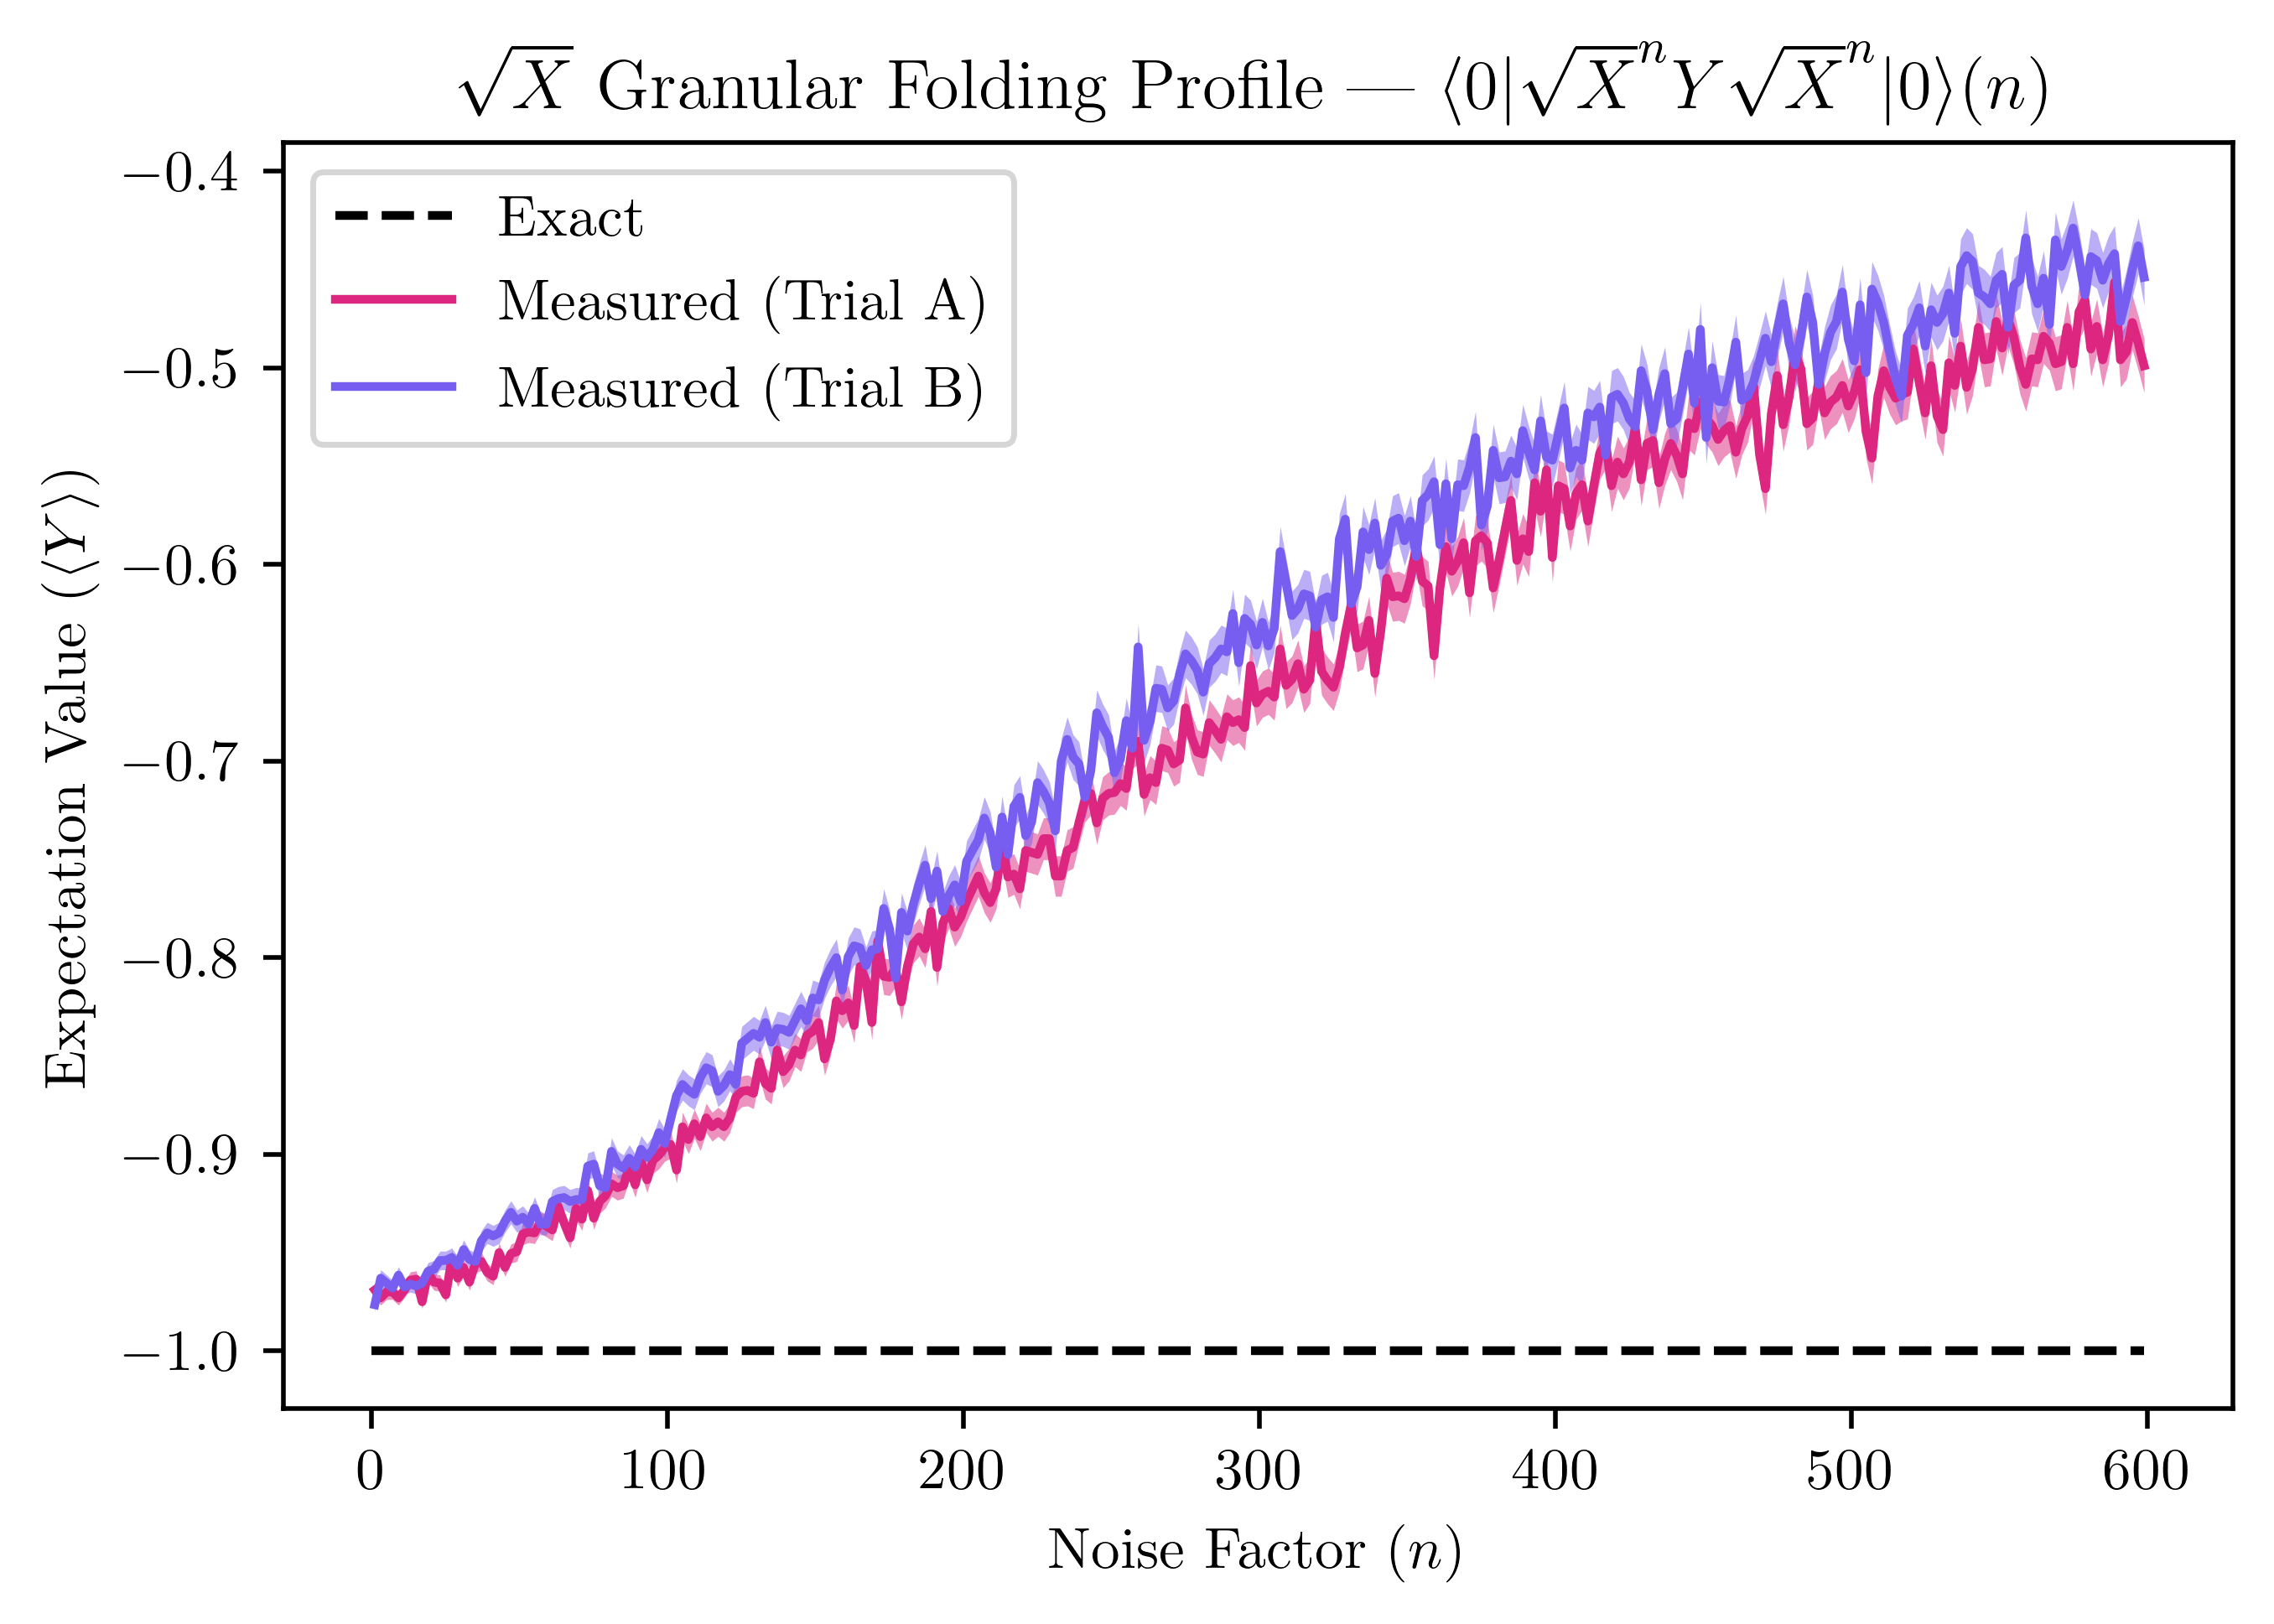

In [71]:
show_experiment([sx_granular_a_data, sx_granular_b_data], sx_exact_ev, "$\sqrt X$ Granular Folding Profile — $\langle 0|{\sqrt X}^nY{\sqrt X}^n|0\\rangle(n)$", 'Y')

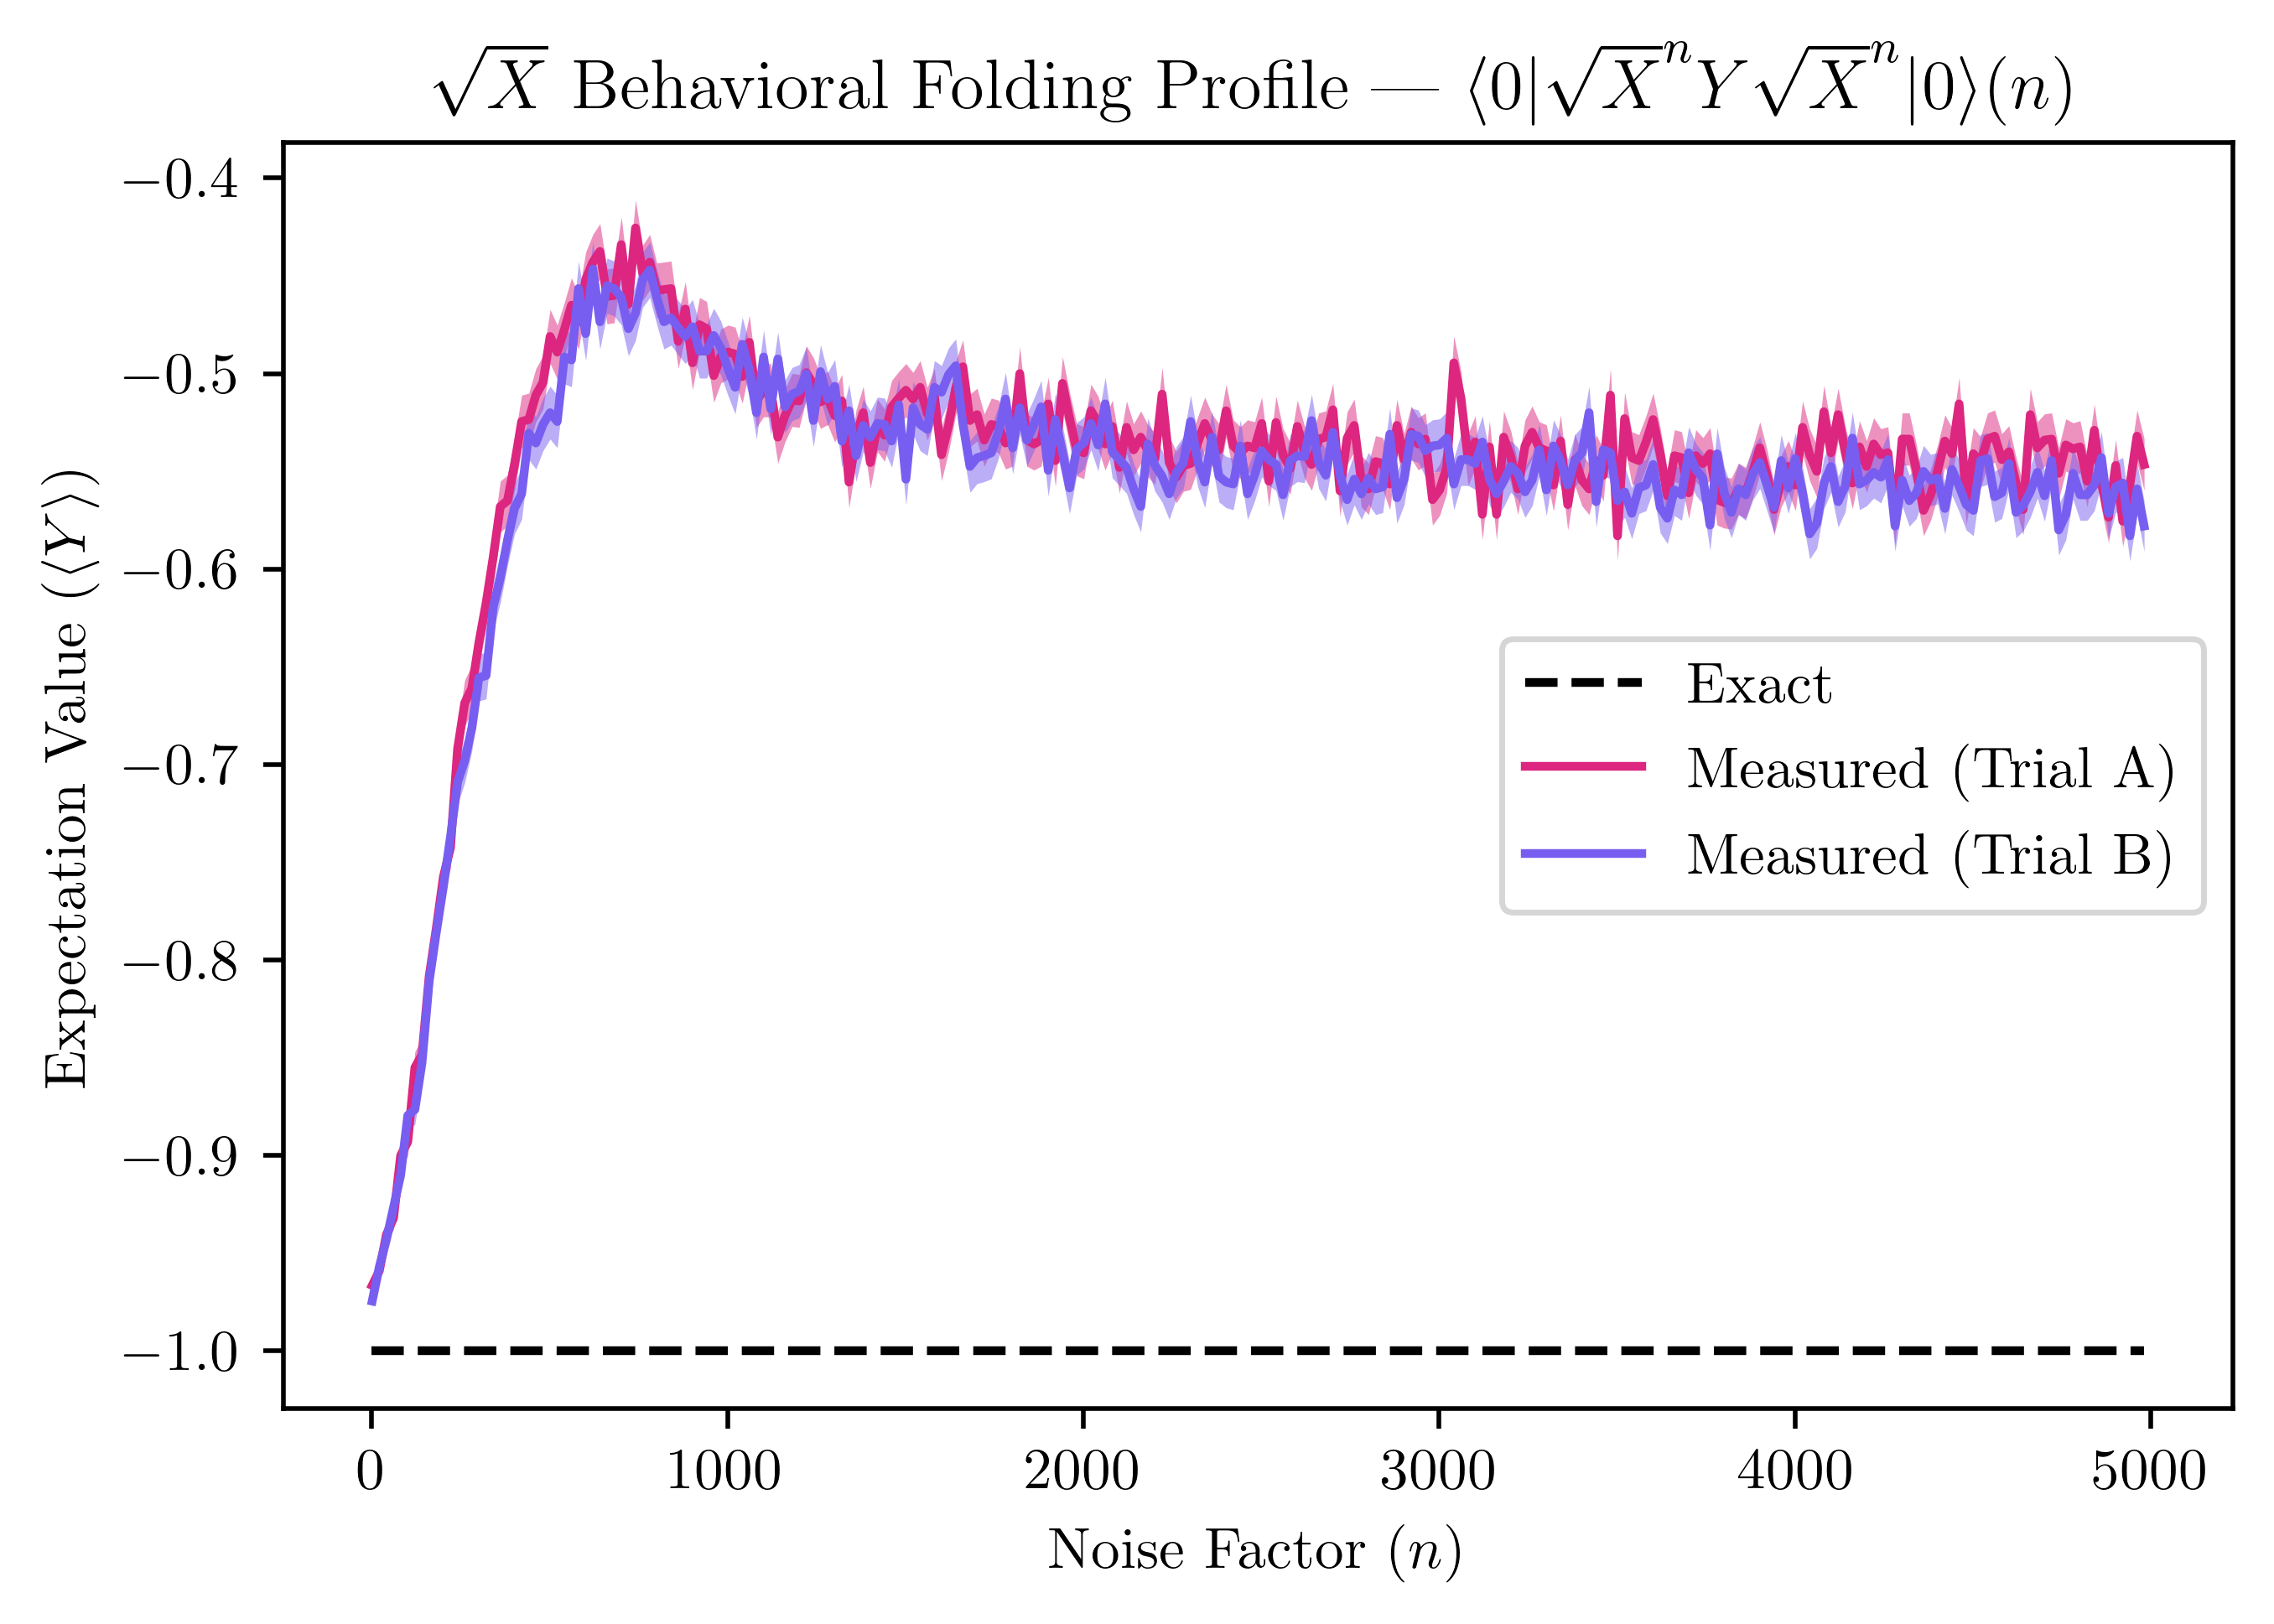

In [72]:
show_experiment([sx_behavioral_a_data, sx_behavioral_b_data], sx_exact_ev, "$\sqrt X$ Behavioral Folding Profile — $\langle 0|{\sqrt X}^nY{\sqrt X}^n|0\\rangle(n)$", 'Y')

The results appear to resemble (albeit less cleanly) a damped sinusoid in the underdamped regime but right around the critical damping threshold.

## $R_Z$ Experiment — $\langle0|H{R_Z(-\frac\pi4)}^nHZH{R_Z(\frac\pi4)}^nH|0\rangle$

### Generate Experiment

For our $R_Z$ experiment, we'll choose our circuit to be a $HR_Z(\frac\pi4)H=R_X(\frac\pi4)$ gate and our observable to be $Z$. The $R_X(\frac\pi4)$ will put our circuit in the state $R_X(\frac\pi4)|0\rangle=\cos\frac\pi8|0\rangle-i\sin\frac\pi8$, and the expectation value of $Z$ is $\left(\cos\frac\pi8\langle0|+i\sin\frac\pi8\langle1|\right)Z\left(\cos\frac\pi8|0\rangle-i\sin\frac\pi8|1\rangle\right)=\left(\cos\frac\pi8\langle0|+i\sin\frac\pi8\langle1|\right)\left(\cos\frac\pi8|0\rangle+i\sin\frac\pi8|1\rangle\right)=\cos^2\frac\pi8-\sin^2\frac\pi8=\cos\frac\pi4=\frac1{\sqrt2}$.

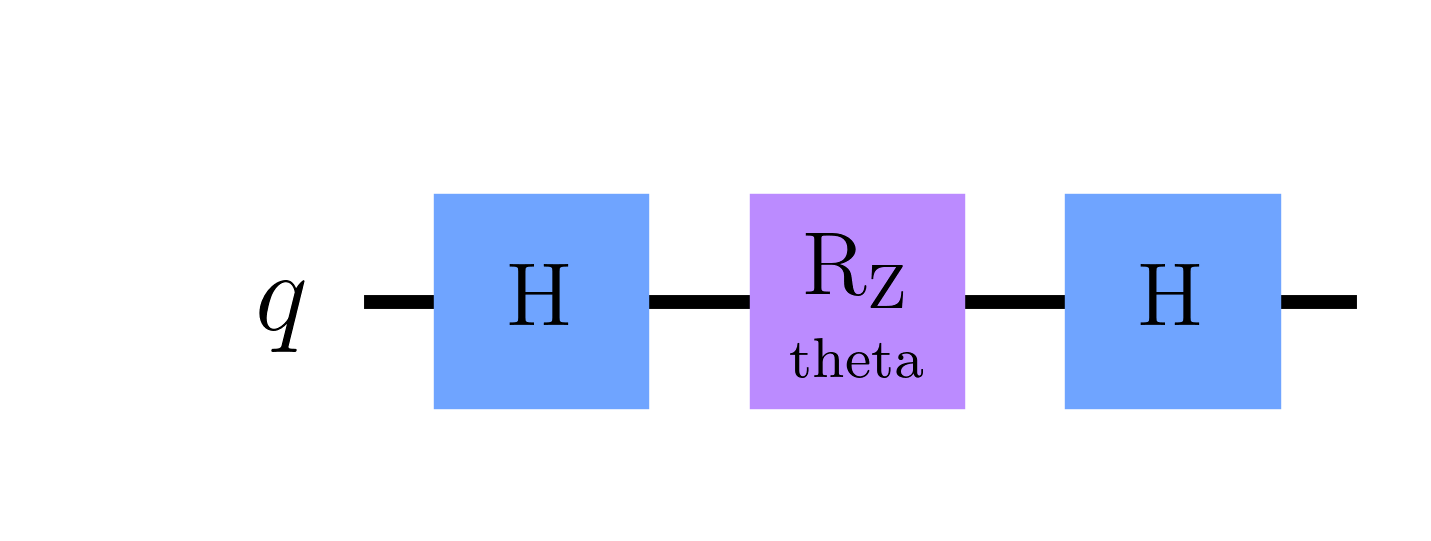

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])
0.7853981633974483
0.7071067811865476


In [73]:
rz_theta = Parameter('theta')

rz_circuit = QuantumCircuit(1)
rz_circuit.h(0)
rz_circuit.rz(rz_theta, 0)
rz_circuit.h(0)

rz_observable = SparsePauliOp.from_list([('Z', 1)])

rz_theta = np.pi / 4
rz_exact_ev = np.cos(rz_theta)

display(rz_circuit.draw('mpl'))
print(rz_observable)
print(rz_theta)
print(rz_exact_ev)

In [65]:
rz_granular_noise_factors = tuple(range(1, 599 + 2, 2))

### Run Experiment

#### Granular

##### Trial A

In [31]:
# with ZneEstimator(
#     circuits=[rz_circuit],
#     observables=[rz_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=rz_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='rz')),
# ) as estimator:
#     rz_granular_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#         parameter_values=[rz_theta]
#     )

# rz_granular_a_data = {
#     "noise_factors": list(rz_granular_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(rz_granular_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(rz_granular_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/rz/rz_granular_a.json', 'w') as f:
#     json.dump(rz_granular_a_data, f)

with open('data/rz/rz_granular_a.json', 'r') as f:
    rz_granular_a_data = json.load(f)

##### Trial B

In [32]:
# with ZneEstimator(
#     circuits=[rz_circuit],
#     observables=[rz_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=rz_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='rz')),
# ) as estimator:
#     rz_granular_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#         parameter_values=[rz_theta]
#     )

# rz_granular_b_data = {
#     "noise_factors": list(rz_granular_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(rz_granular_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(rz_granular_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/rz/rz_granular_b.json', 'w') as f:
#     json.dump(rz_granular_b_data, f)

with open('data/rz/rz_granular_b.json', 'r') as f:
    rz_granular_b_data = json.load(f)

### Plot Results

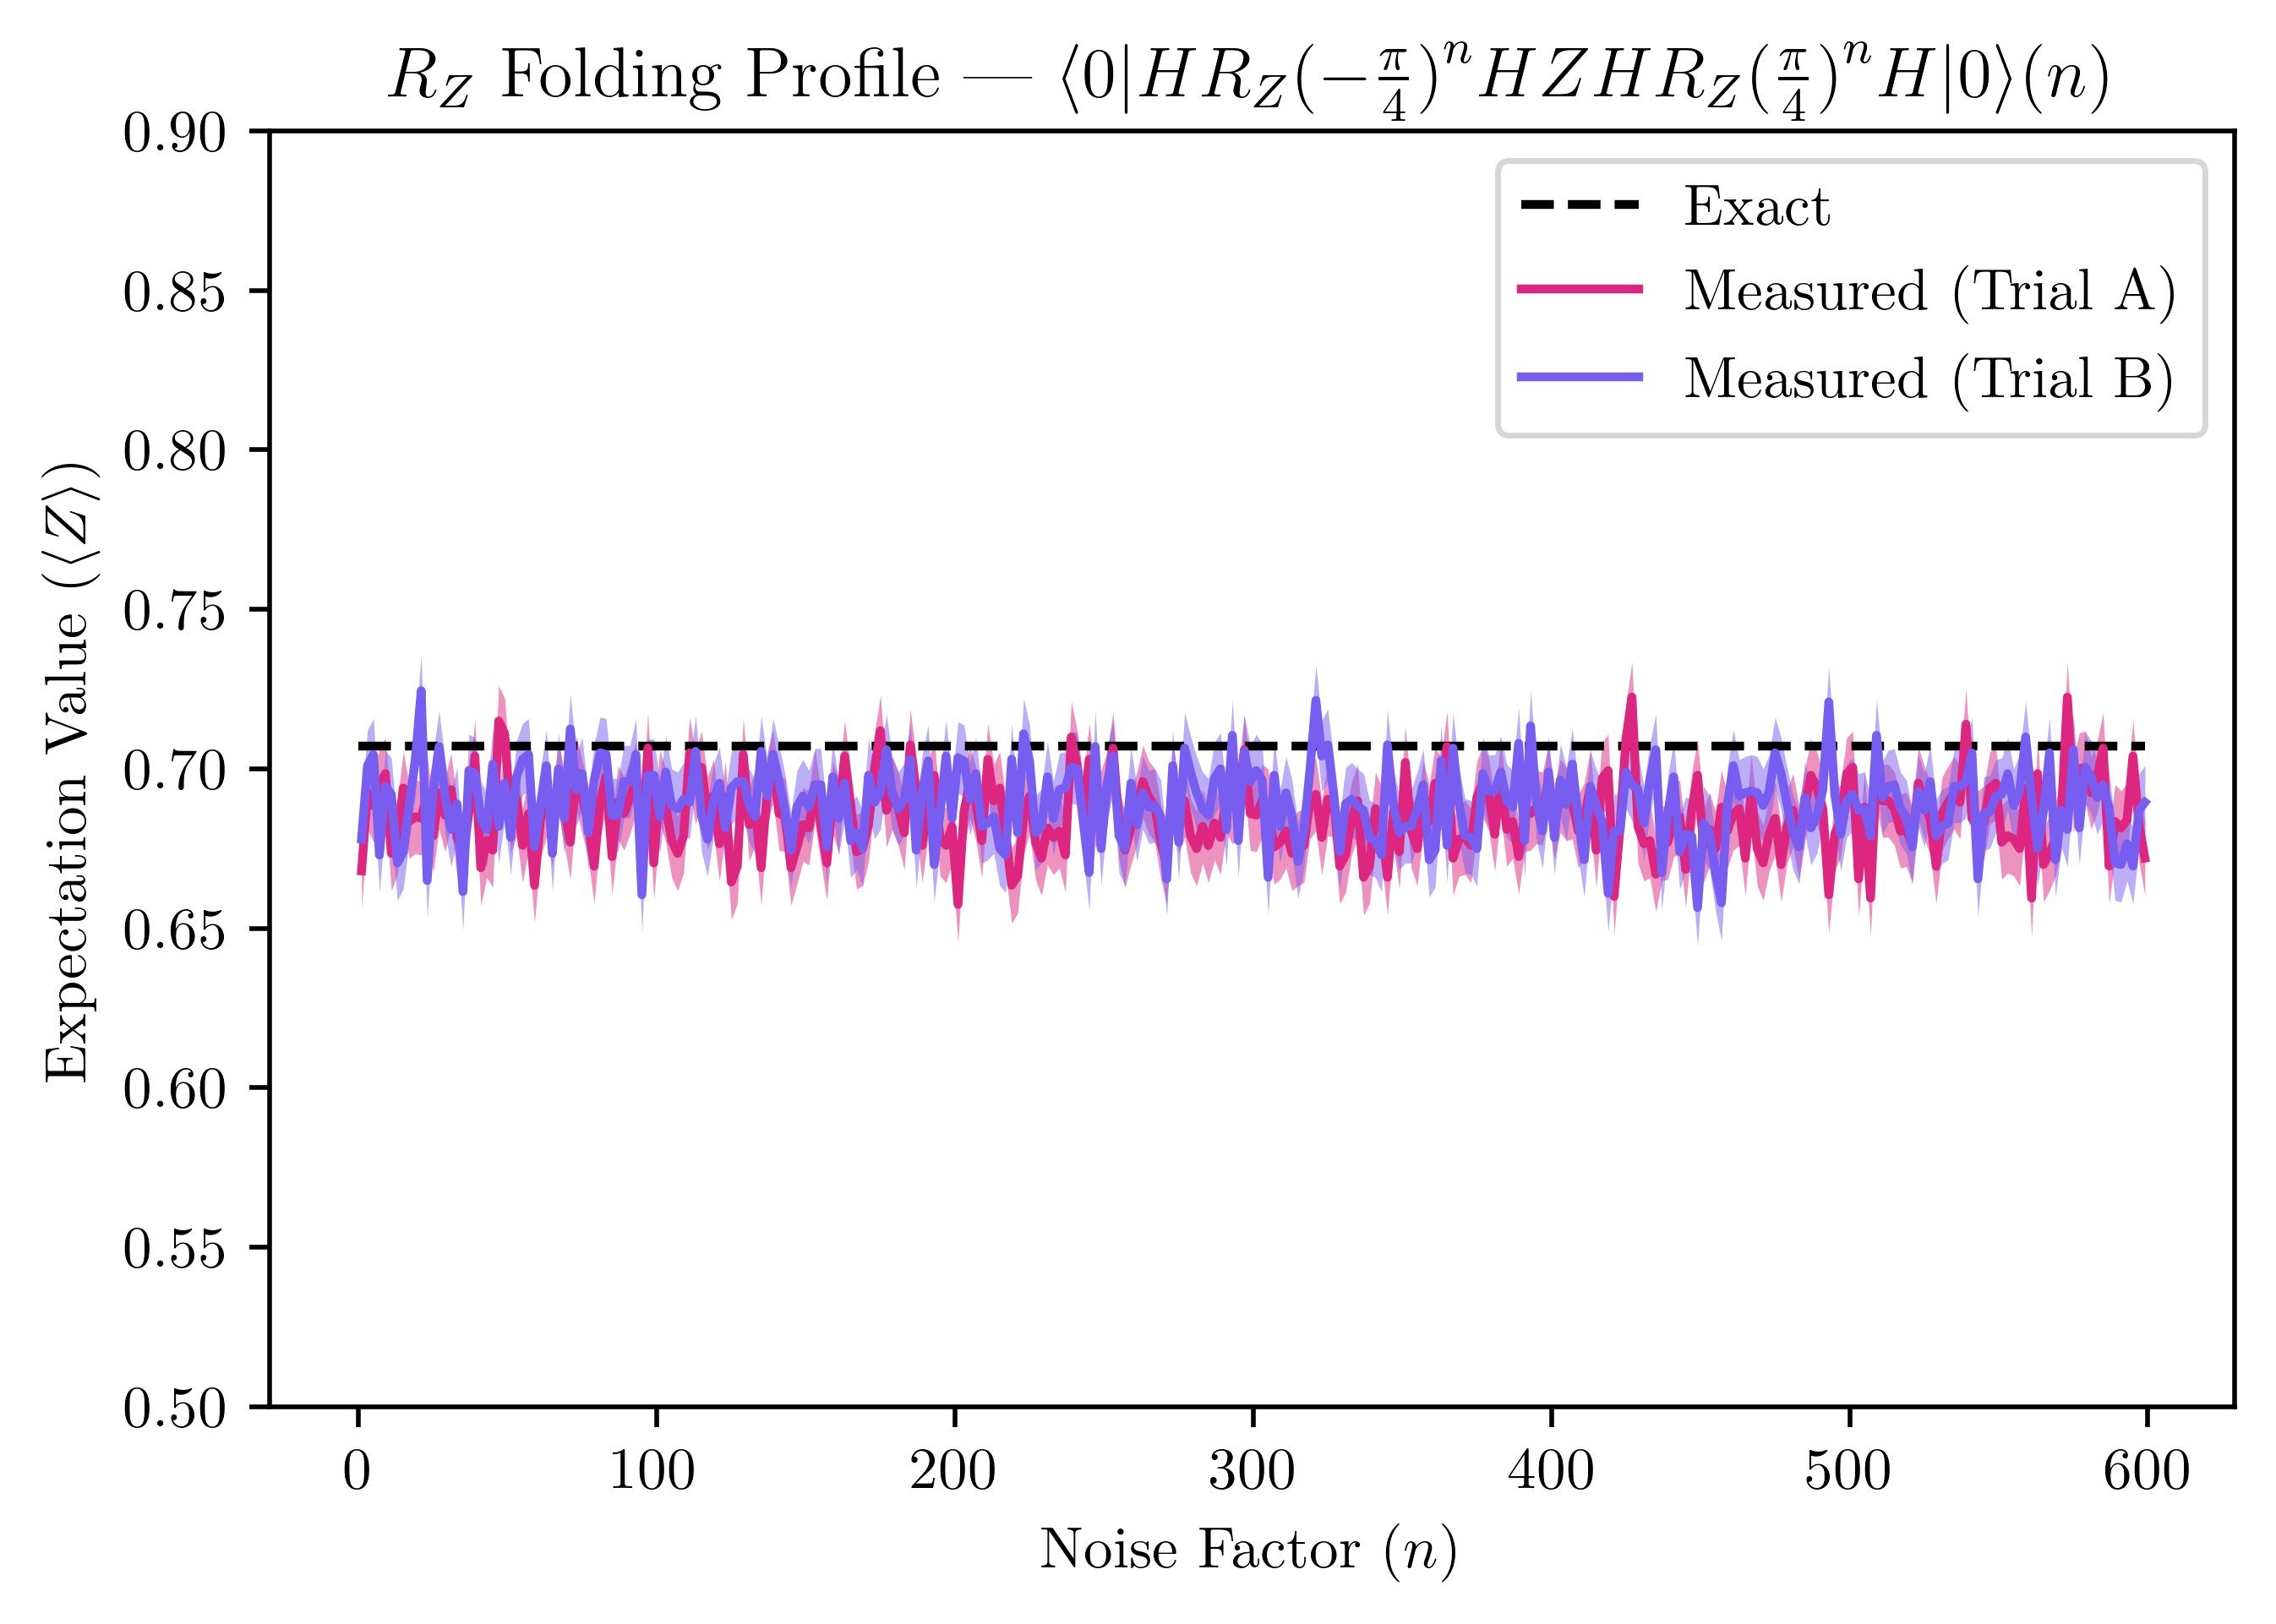

In [74]:
show_experiment([rz_granular_a_data, rz_granular_b_data], rz_exact_ev, "$R_Z$ Folding Profile — $\langle0|H{R_Z(-\\frac\pi4)}^nHZH{R_Z(\\frac\pi4)}^nH|0\\rangle(n)$", 'Z', ev_range=(0.5, 0.9))

The results seem to indicate that folding $R_Z$ gates doesn't significantly change the state of the circuit as represented on the quantum hardware. This is expected as $R_Z$ gates are implemented [virtually](https://arxiv.org/abs/1612.00858).

## $CX$ Experiment — $\langle 00|(IX)(CX)^n(ZI)(CX)^n(IX)|00\rangle$

### Generate Experiment

For our $CX$ experiment, we'll choose our circuit to be a $CX$ preceded by an $X$ on the control qubit and our observable to be $ZI$. The $X$ will flip the control qubit to $|1\rangle$ causing the $CX$ to flip the target qubit to $|1\rangle$. Thus, estimating the expectation value of $Z$ on the target qubit should give $\langle 1|Z|1 \rangle=-\langle 1|1 \rangle= -1$.

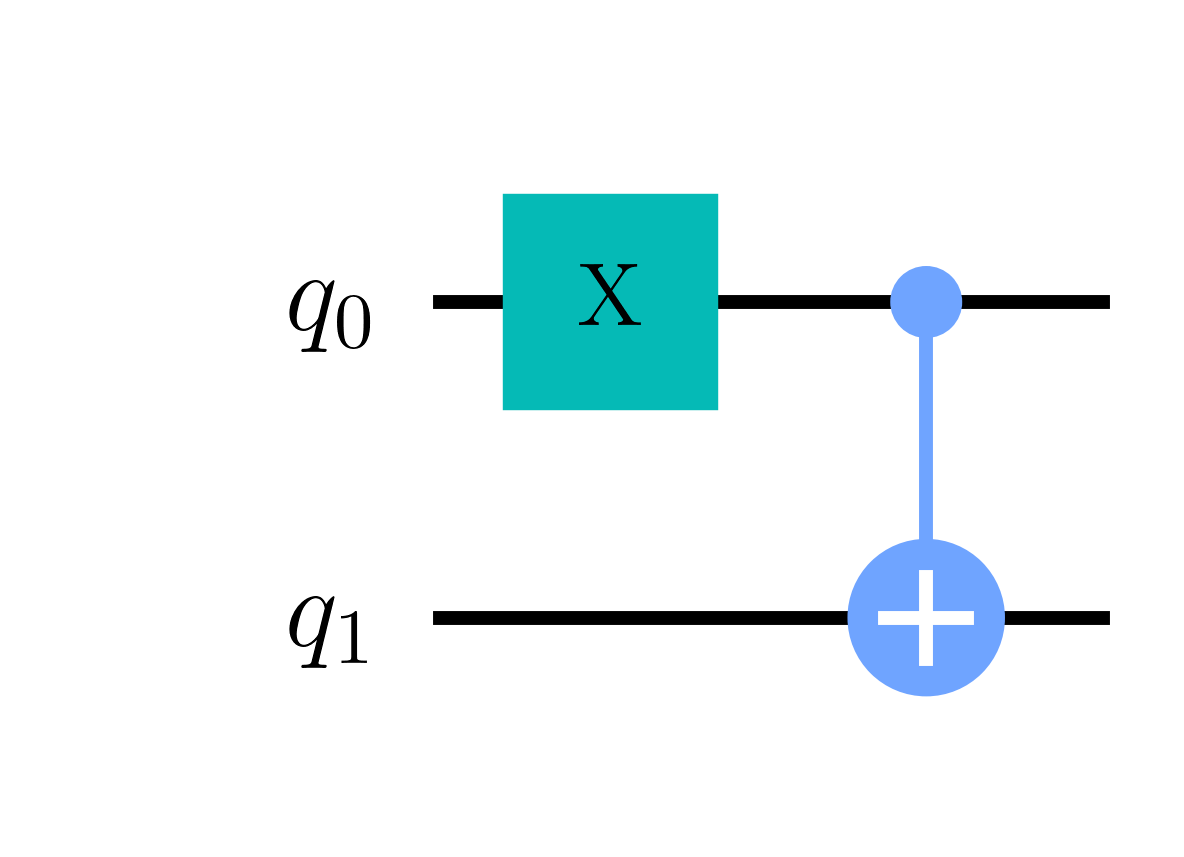

SparsePauliOp(['ZI'],
              coeffs=[1.+0.j])
-1.0


In [75]:
cx_circuit = QuantumCircuit(2)
cx_circuit.x(0)
cx_circuit.cx(0, 1)

cx_observable = SparsePauliOp.from_list([('ZI', 1)])

cx_exact_ev = -1.0

display(cx_circuit.draw("mpl"))
print(cx_observable)
print(cx_exact_ev)

In [35]:
cx_granular_noise_factors = tuple(range(1, 599 + 2, 2))
cx_behavioral_noise_factors = tuple(range(1, 5999, 20))

### Run Experiment

#### Granular

##### Trial A

In [36]:
# with ZneEstimator(
#     circuits=[cx_circuit],
#     observables=[cx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=cx_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='cx')),
# ) as estimator:
#     cx_granular_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# cx_granular_a_data = {
#     "noise_factors": list(cx_granular_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(cx_granular_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(cx_granular_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/cx/cx_granular_a.json', 'w') as f:
#     json.dump(cx_granular_a_data, f)

with open('data/cx/cx_granular_a.json', 'r') as f:
    cx_granular_a_data = json.load(f)

##### Trial B

In [37]:
# with ZneEstimator(
#     circuits=[cx_circuit],
#     observables=[cx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=cx_granular_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='cx')),
# ) as estimator:
#     cx_granular_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# cx_granular_b_data = {
#     "noise_factors": list(cx_granular_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(cx_granular_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(cx_granular_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/cx/cx_granular_b.json', 'w') as f:
#     json.dump(cx_granular_b_data, f)

with open('data/cx/cx_granular_b.json', 'r') as f:
    cx_granular_b_data = json.load(f)

#### Behavioral

##### Trial A

In [38]:
# with ZneEstimator(
#     circuits=[cx_circuit],
#     observables=[cx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=cx_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='cx')),
# ) as estimator:
#     cx_behavioral_a_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# cx_behavioral_a_data = {
#     "noise_factors": list(cx_behavioral_a_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(cx_behavioral_a_results.metadata[0]["zne"]["values"]),
#     "variances": list(cx_behavioral_a_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/cx/cx_behavioral_a.json', 'w') as f:
#     json.dump(cx_behavioral_a_data, f)

with open('data/cx/cx_behavioral_a.json', 'r') as f:
    cx_behavioral_a_data = json.load(f)

##### Trial B

In [39]:
# with ZneEstimator(
#     circuits=[cx_circuit],
#     observables=[cx_observable],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=cx_behavioral_noise_factors, noise_amplifier=SingleGateFoldingAmplifier(gate_name='cx')),
# ) as estimator:
#     cx_behavioral_b_results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# cx_behavioral_b_data = {
#     "noise_factors": list(cx_behavioral_b_results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(cx_behavioral_b_results.metadata[0]["zne"]["values"]),
#     "variances": list(cx_behavioral_b_results.metadata[0]["zne"]["variances"]),
# }

# with open('data/cx/cx_behavioral_b.json', 'w') as f:
#     json.dump(cx_behavioral_b_data, f)

with open('data/cx/cx_behavioral_b.json', 'r') as f:
    cx_behavioral_b_data = json.load(f)

### Plot Results

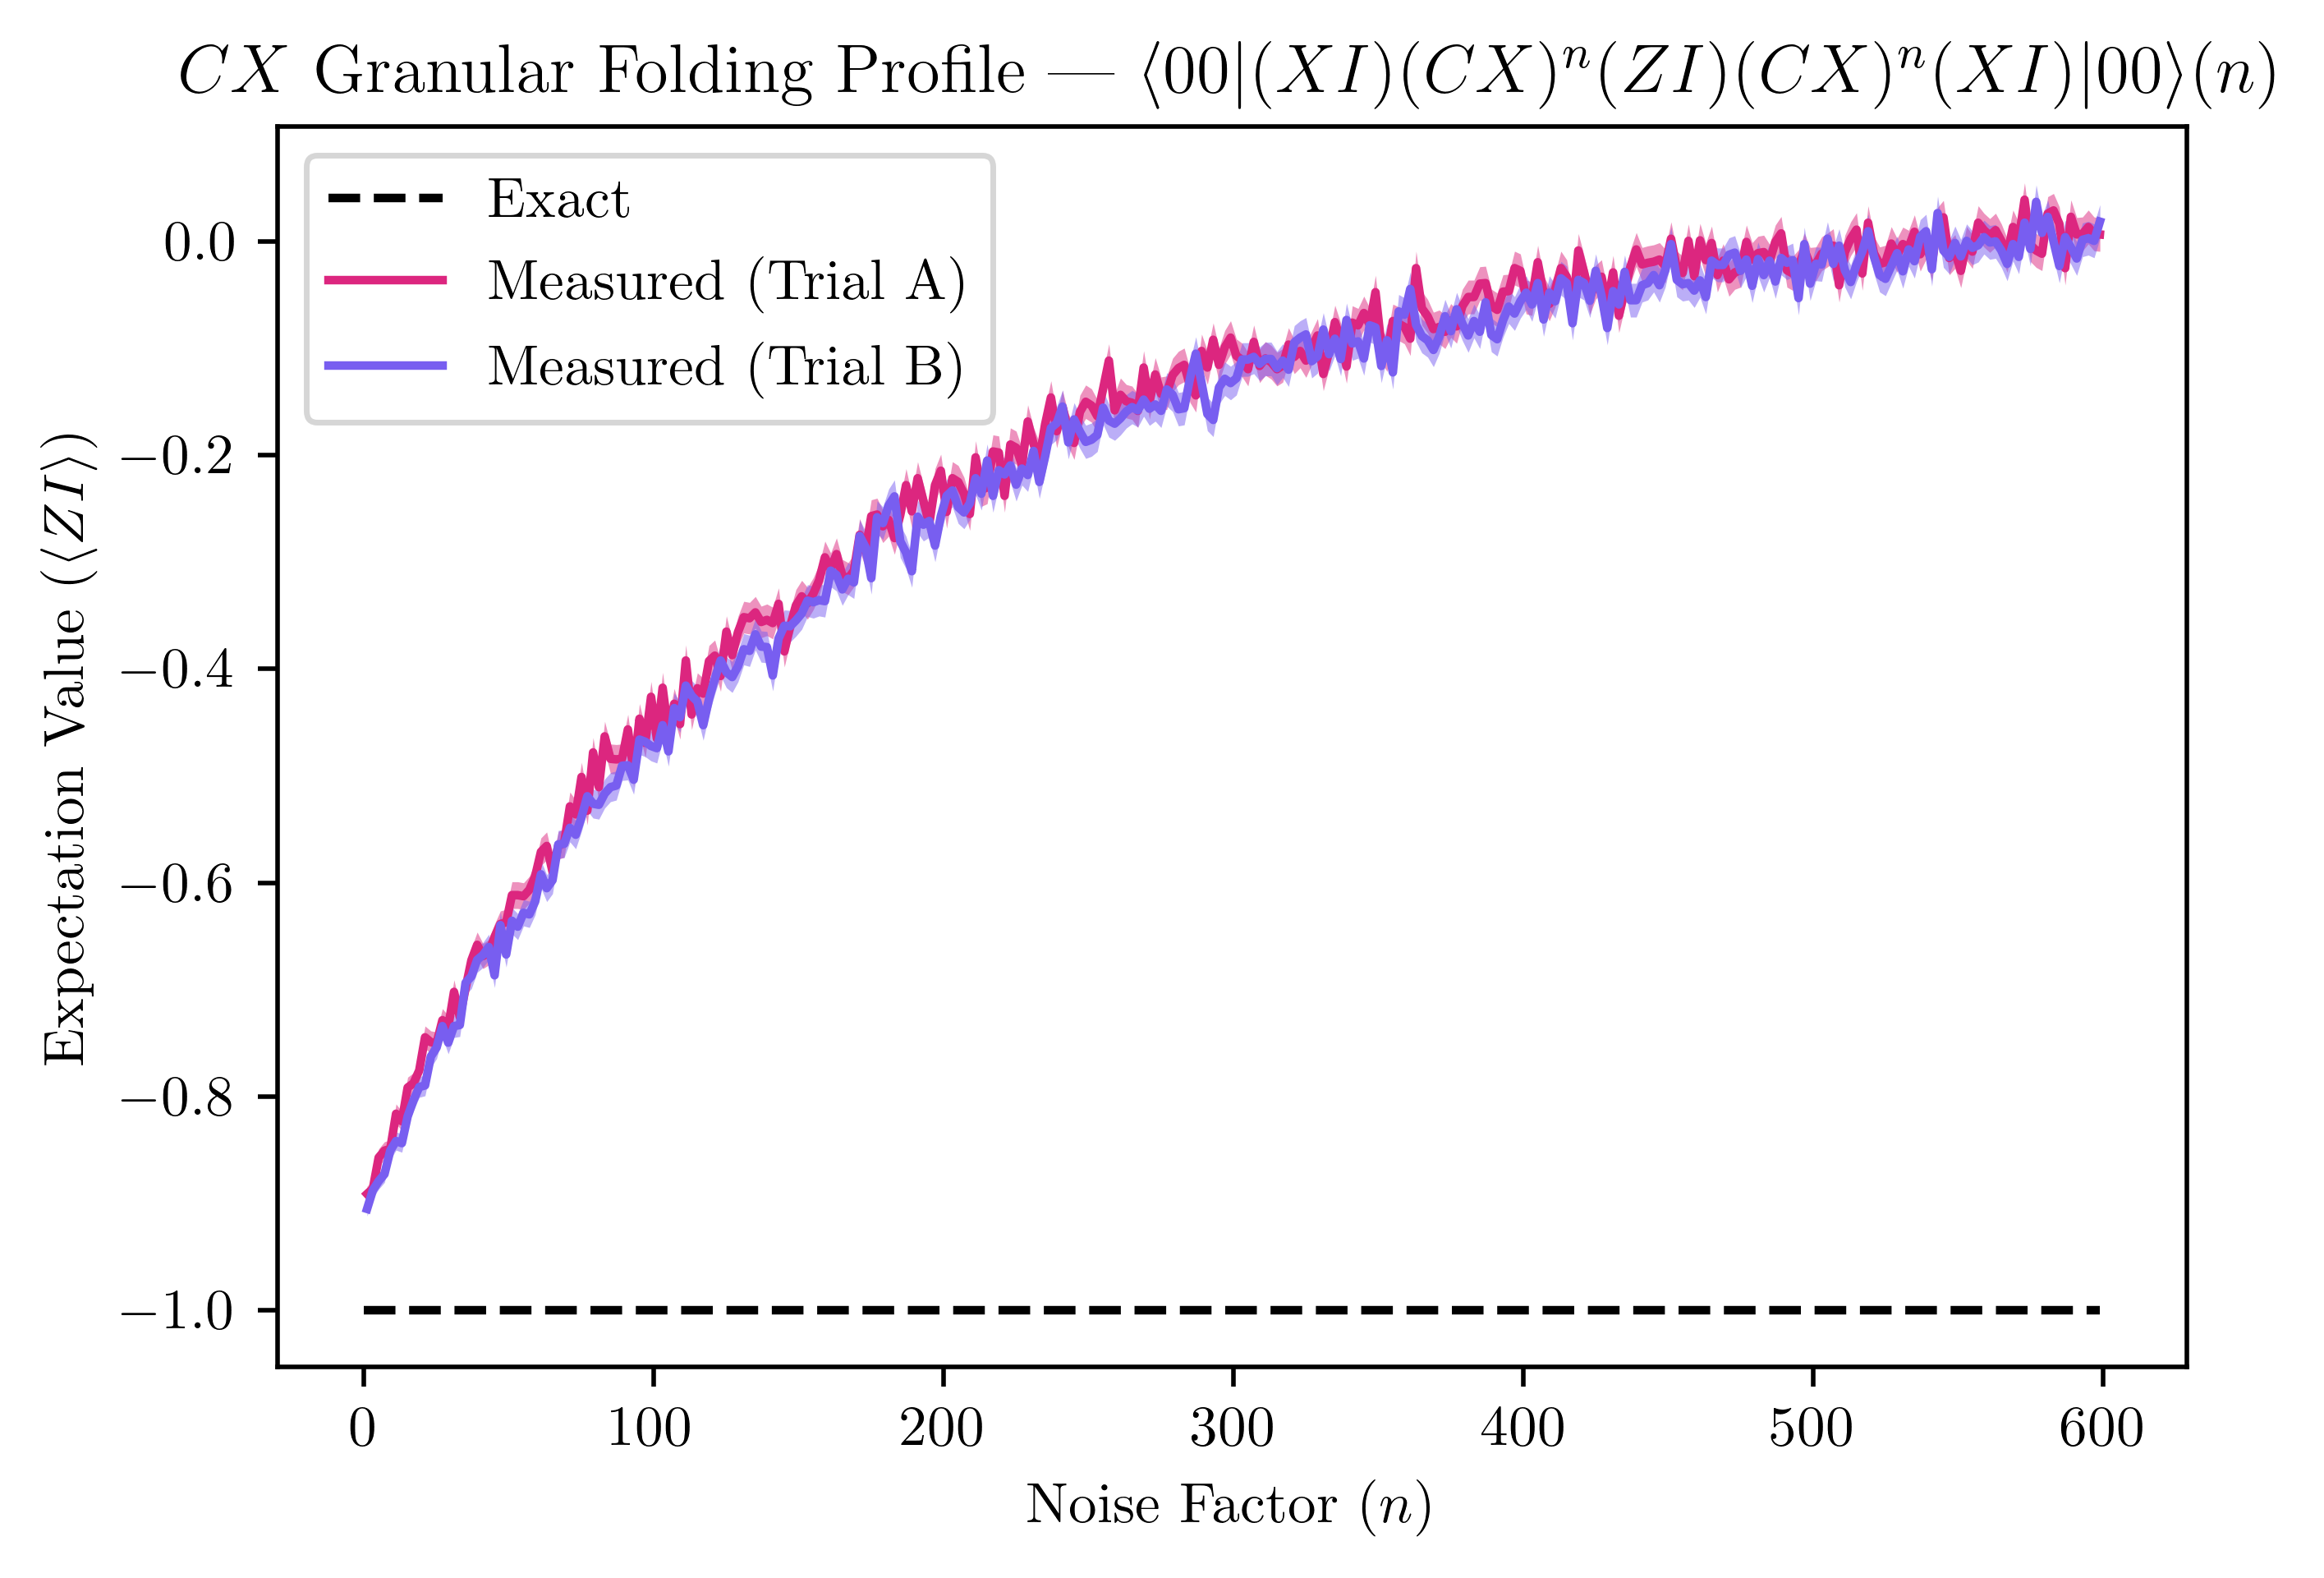

In [76]:
show_experiment([cx_granular_a_data, cx_granular_b_data], cx_exact_ev, "$CX$ Granular Folding Profile —  $\langle 00|(XI)({CX})^n(ZI)({CX})^n(XI)|00\\rangle(n)$", 'ZI')

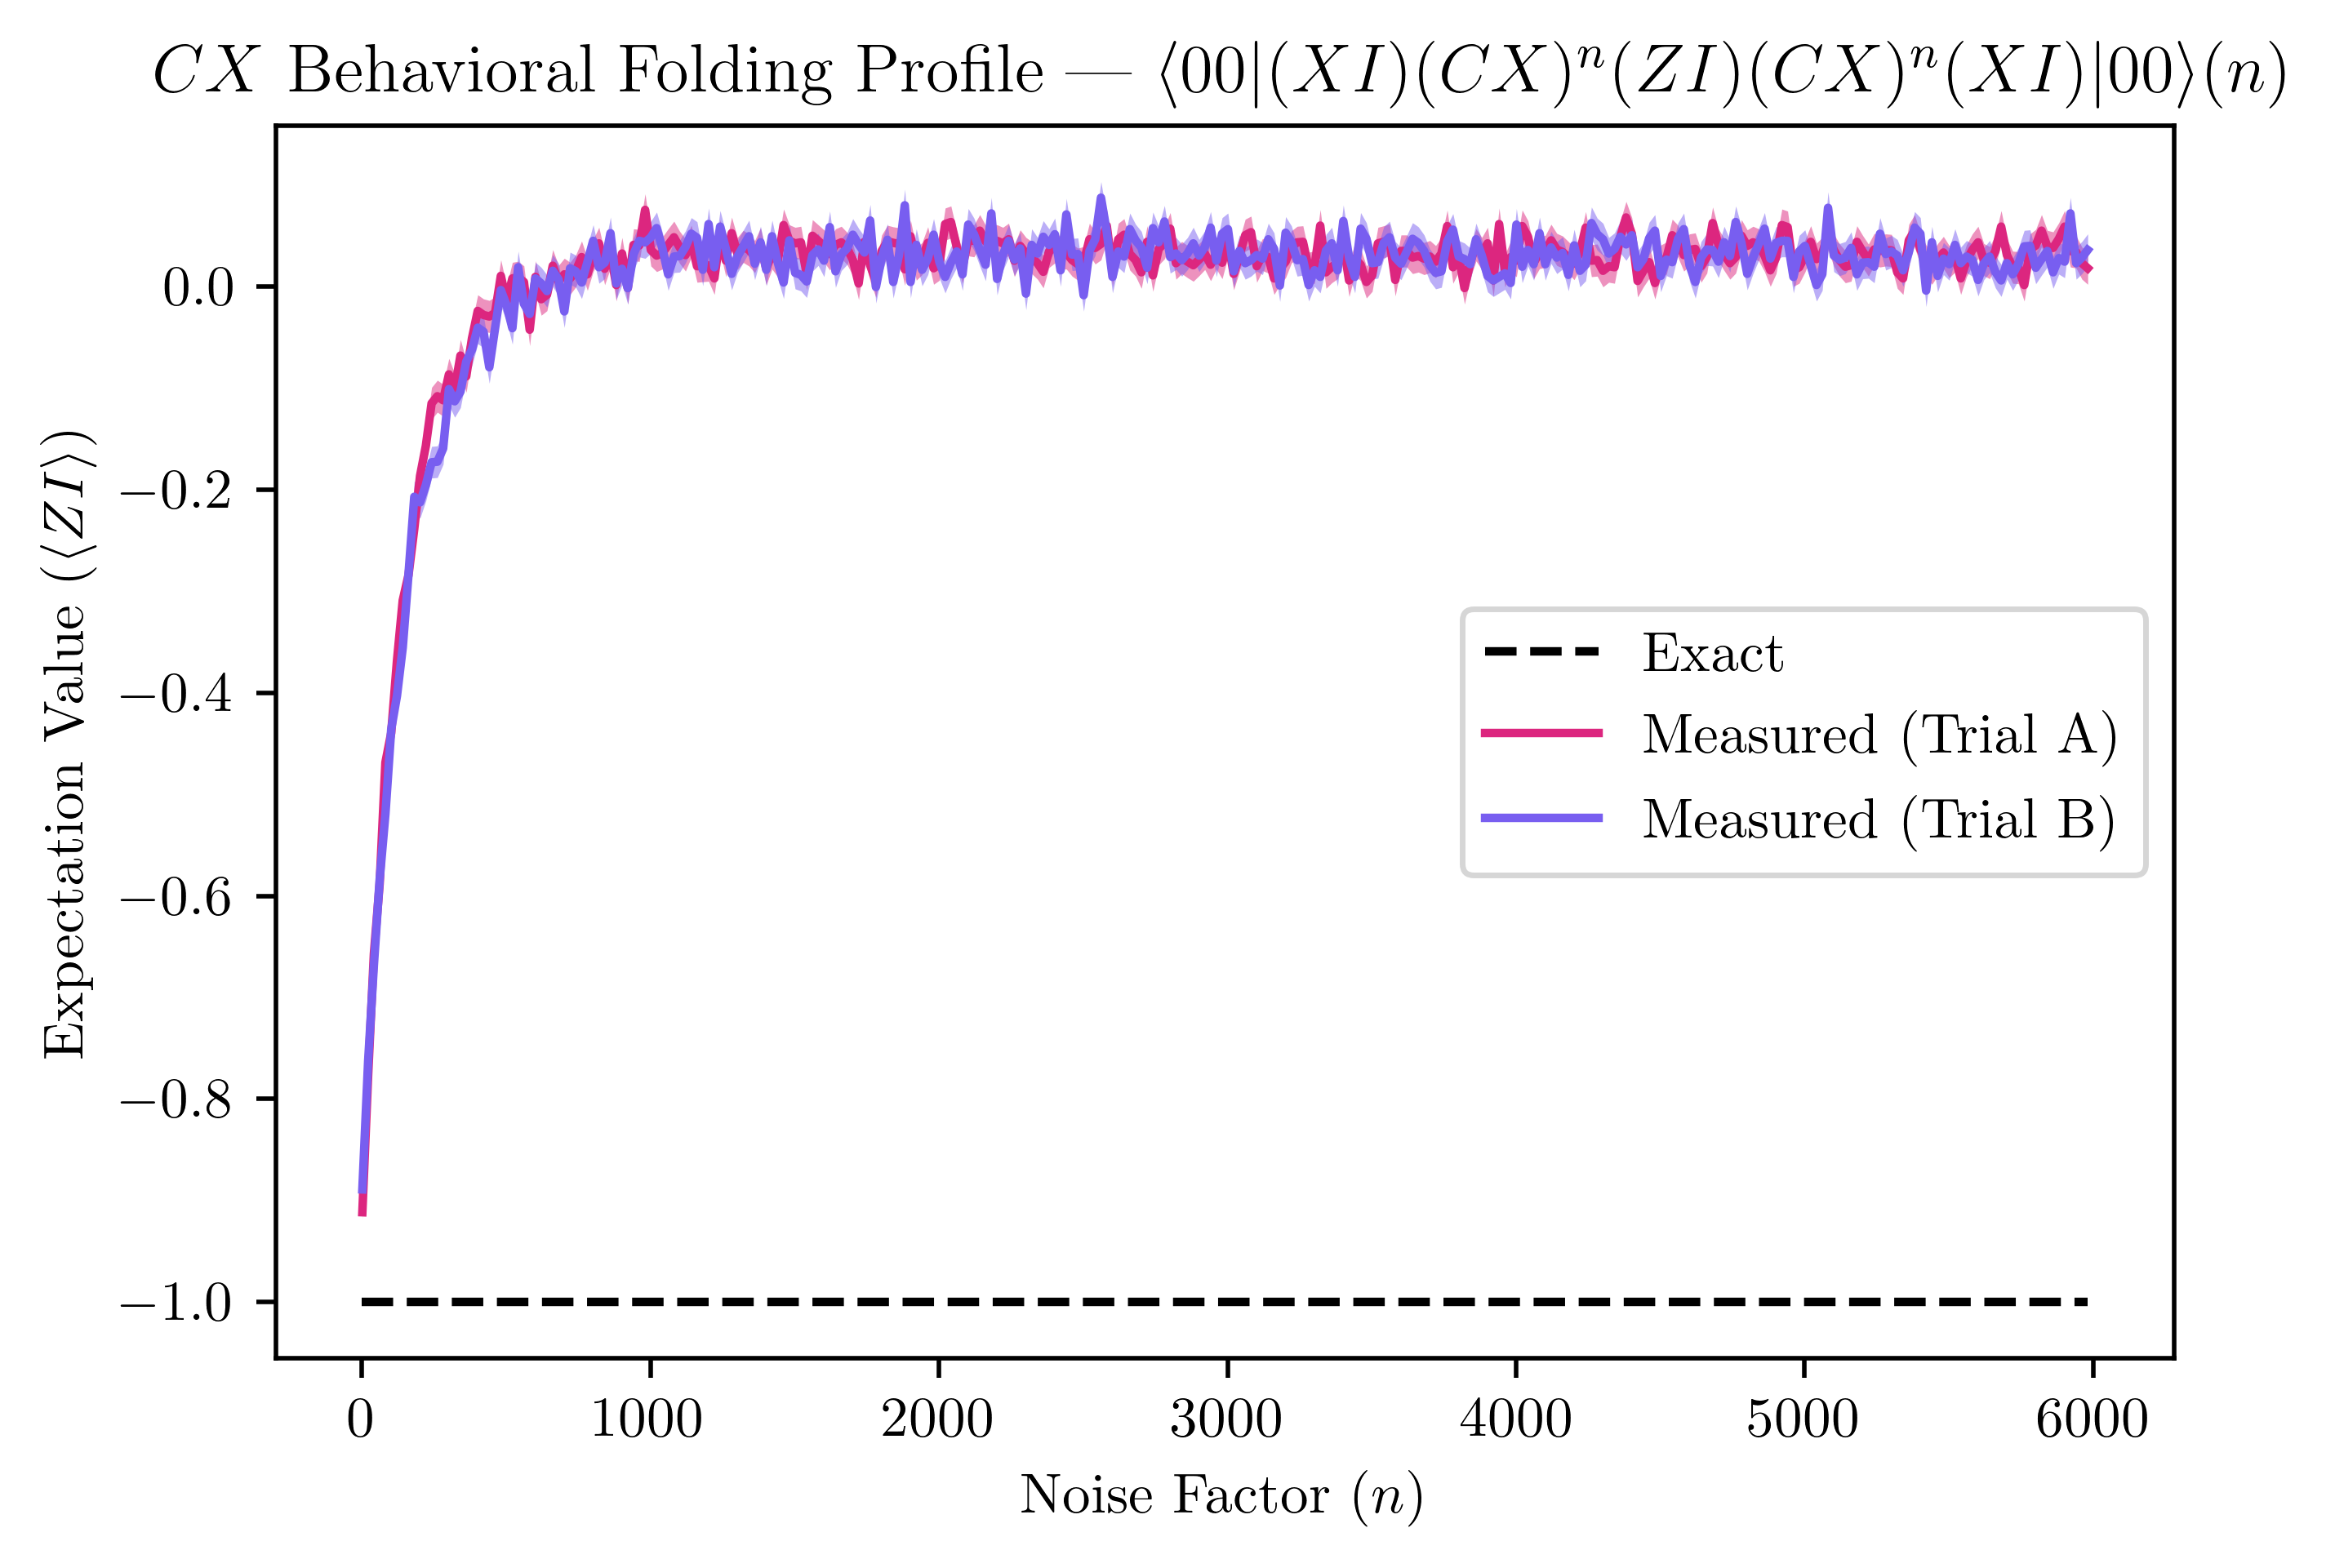

In [77]:
show_experiment([cx_behavioral_a_data, cx_behavioral_b_data], cx_exact_ev, "$CX$ Behavioral Folding Profile —  $\langle 00|(XI)({CX})^n(ZI)({CX})^n(XI)|00\\rangle(n)$", 'ZI')

The results appear to resemble exponential decay; more generally perhaps a damped sinusoid in the overdamped regime.

Hopefully you now have a sense of how amplifying the noise of the basis gates of a device using gate folding affects estimation of expectation values on real quantum hardware!